In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


In [4]:
def unit(x, scale=1):
    _x = x ** scale
    _x = _x - torch.min(torch.min(_x), torch.zeros_like(_x))
    return _x / torch.max(_x)

def plot_magn(magn):
    scaled = magn ** 0.1
    plot(scaled / torch.max(scaled))
    
def plot_phase(phase):
    plot((phase + math.pi) / (2 * math.pi))

fashion


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


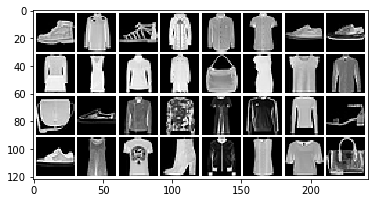

torch.Size([32, 1, 28, 28])


In [5]:
### LOAD DATA ###

dataset = 'fashion'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft ** 2, -1))
sample_phases = torch.atan2(sample_ft[..., 1], sample_ft[..., 0])

plot_grid(sample)
print(sample_magnitudes.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Magnitudes in real space:


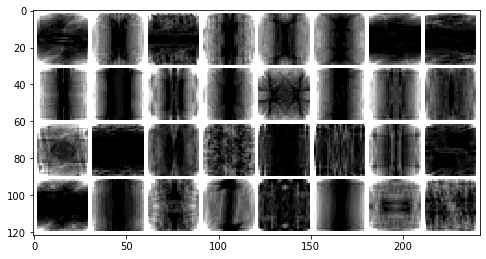

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 28, 28])
Phases in real space:


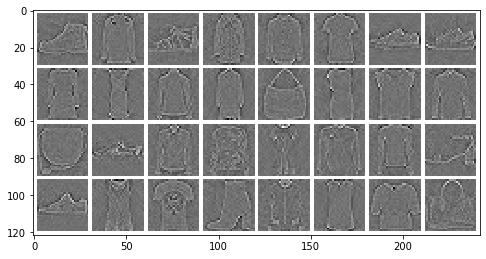

torch.Size([32, 1, 28, 28])
Min: tensor(-0.2509) Max: tensor(0.3180)
Mean: tensor(0.0013) Std: tensor(0.0357)


In [6]:
### Convert magnitudes and phasesto real space ###

# Set Im part of magnitudes = 0 and show in real space
sample_magn_real = nn.functional.pad(sample_magnitudes[... , None], (0, 1), 'constant', 0)
sample_Magn = torch.irfft(sample_magn_real, 2, onesided=False)

# Expand the magnitudes to Real and Im dimension and delete them from the phases
sample_magnitudes_cmplx = sample_magnitudes[..., None].expand(*sample_magnitudes.shape, 2)
sample_phases_cmplx = (sample_ft / (1e-16 + sample_magnitudes_cmplx))
sample_Phases = torch.irfft(sample_phases_cmplx, 2, onesided=False)

print("Magnitudes in real space:")
plot_grid(sample_Magn, figsize=(8,8))
print(sample_Magn.shape)

print("Phases in real space:")
plot_grid(unit(sample_Phases), figsize=(8,8))
print(sample_Phases.shape)
print("Min:", torch.min(sample_Phases), "Max:", torch.max(sample_Phases))
print("Mean:", torch.mean(sample_Phases), "Std:", torch.std(sample_Phases))

In [7]:
# Fully connected image network
class FCNet(nn.Module):

    __constants__ = ['mean', 'std']

    def __init__(self, imsize=(1, 28, 28), outsize=None, h=2048, mean=None, std=None):
        super(FCNet, self).__init__()
        print("Version 0.4")
        self.imsize = imsize
        if outsize is None:
            self.outsize = imsize
        else:
            self.outsize = outsize
        
        if mean is None:
            self.register_buffer('mean', torch.zeros(imsize))
        else:
            self.register_buffer('mean', torch.Tensor(mean))

        if std is None:
            self.register_buffer('std', torch.ones(imsize))
        else:
            self.register_buffer('std', torch.Tensor(std))
        
        self.layers = nn.Sequential(
            nn.Linear(imsize[0] * imsize[1] * imsize[2], h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h, self.outsize[0] * self.outsize[1] * self.outsize[2]),
        )
        
    def forward(self, x):
    
        N = x.shape[0]

        out = 0.0357 * self.layers(x.view(N, -1))
        return out.view(N, *self.outsize)

In [8]:
def calc_fourier(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    phs = torch.atan2(ft[..., 1], ft[..., 0])
    return ft, mags, phs

def calc_fourier_real(ft, mags):
    magn_real = nn.functional.pad(mags[... , None], (0, 1), 'constant', 0)
    Magns = torch.irfft(magn_real, 2, onesided=False)
    magnitudes_cmplx = mags[..., None].expand(*mags.shape, 2)
    phases_cmplx = (ft / (1e-16 + magnitudes_cmplx))
    Phases = torch.irfft(phases_cmplx, 2, onesided=False)
    return Magns, Phases

In [9]:
# Define loss

def gen_loss(Phase1, Phase2):
    return torch.mean((Phase1 - Phase2) ** 2)

In [10]:
### Create new models ###

gen = FCNet(imsize=(1, 28, 28), outsize=(1, 28, 28), h=2048)

Version 0.4


In [11]:
# Set training parameters

history = []
opt = optim.Adam(gen.parameters(), lr=1e-3)

In [12]:
# Initial loss

gen = gen.to(device)
sample = sample.to(device)
sample_ft, sample_magn, _ = calc_fourier(sample)
sample_Magns, sample_Phs = calc_fourier_real(sample_ft, sample_magn)

pred_Phs = gen(sample_magn)

loss = gen_loss(pred_Phs, sample_Phs)

print("Generator loss:", loss.item())

Generator loss: 0.0013494399609044194


In [13]:
def train_model(model, optimizer, device, loader_train, epochs=1):

    # move the model parameters to CPU/GPU
    model = model.to(device=device)
    
    history = []
    
    for e in range(epochs):

        for t, x in enumerate(loader_train):
            # put model to training mode
            model.train()
            
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)

            ft, magn, _ = calc_fourier(x)
            _, Phs = calc_fourier_real(ft, magn)
            
            # compute loss as pixel wise distance to original input
            pred_Phs = model(magn)
            
            loss = gen_loss(pred_Phs, Phs)
            #loss = torch.mean((x - out_real)**2) + torch.mean((phases - out_phases)**2)
            history.append(loss.item())

            # perform backprop and learning step
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history[-1]))
                
        plt.plot(history)
        plt.show()
                
    return history

epoch:  1 	 step:0 	 loss: 0.001346
epoch:  1 	 step:100 	 loss: 0.001161
epoch:  1 	 step:200 	 loss: 0.001148
epoch:  1 	 step:300 	 loss: 0.001163
epoch:  1 	 step:400 	 loss: 0.001135
epoch:  1 	 step:500 	 loss: 0.001141
epoch:  1 	 step:600 	 loss: 0.001144
epoch:  1 	 step:700 	 loss: 0.001119
epoch:  1 	 step:800 	 loss: 0.001171
epoch:  1 	 step:900 	 loss: 0.001116
epoch:  1 	 step:1000 	 loss: 0.001104
epoch:  1 	 step:1100 	 loss: 0.001084
epoch:  1 	 step:1200 	 loss: 0.001083
epoch:  1 	 step:1300 	 loss: 0.001064
epoch:  1 	 step:1400 	 loss: 0.001126
epoch:  1 	 step:1500 	 loss: 0.001111
epoch:  1 	 step:1600 	 loss: 0.001097
epoch:  1 	 step:1700 	 loss: 0.001062
epoch:  1 	 step:1800 	 loss: 0.001049


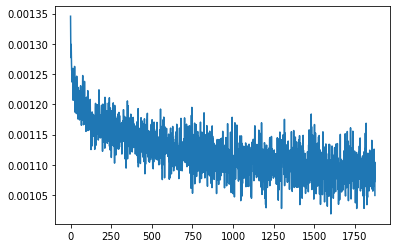

epoch:  2 	 step:0 	 loss: 0.001066
epoch:  2 	 step:100 	 loss: 0.001099
epoch:  2 	 step:200 	 loss: 0.001067
epoch:  2 	 step:300 	 loss: 0.001068
epoch:  2 	 step:400 	 loss: 0.001085
epoch:  2 	 step:500 	 loss: 0.001149
epoch:  2 	 step:600 	 loss: 0.001077
epoch:  2 	 step:700 	 loss: 0.001069
epoch:  2 	 step:800 	 loss: 0.001042
epoch:  2 	 step:900 	 loss: 0.001068
epoch:  2 	 step:1000 	 loss: 0.001021
epoch:  2 	 step:1100 	 loss: 0.001093
epoch:  2 	 step:1200 	 loss: 0.001073
epoch:  2 	 step:1300 	 loss: 0.001072
epoch:  2 	 step:1400 	 loss: 0.0009668
epoch:  2 	 step:1500 	 loss: 0.001079
epoch:  2 	 step:1600 	 loss: 0.001063
epoch:  2 	 step:1700 	 loss: 0.001105
epoch:  2 	 step:1800 	 loss: 0.001083


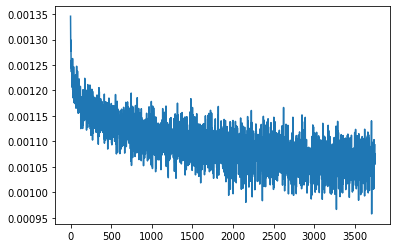

epoch:  3 	 step:0 	 loss: 0.001018
epoch:  3 	 step:100 	 loss: 0.001045
epoch:  3 	 step:200 	 loss: 0.001089
epoch:  3 	 step:300 	 loss: 0.001074
epoch:  3 	 step:400 	 loss: 0.001066
epoch:  3 	 step:500 	 loss: 0.001088
epoch:  3 	 step:600 	 loss: 0.001073
epoch:  3 	 step:700 	 loss: 0.001054
epoch:  3 	 step:800 	 loss: 0.001068
epoch:  3 	 step:900 	 loss: 0.001016
epoch:  3 	 step:1000 	 loss: 0.00102
epoch:  3 	 step:1100 	 loss: 0.001065
epoch:  3 	 step:1200 	 loss: 0.001009
epoch:  3 	 step:1300 	 loss: 0.001057
epoch:  3 	 step:1400 	 loss: 0.001001
epoch:  3 	 step:1500 	 loss: 0.001047
epoch:  3 	 step:1600 	 loss: 0.001024
epoch:  3 	 step:1700 	 loss: 0.001009
epoch:  3 	 step:1800 	 loss: 0.001051


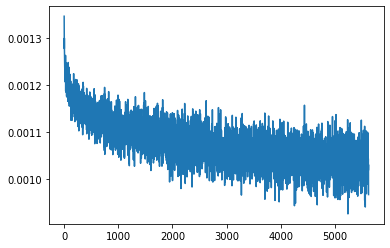

epoch:  4 	 step:0 	 loss: 0.001009
epoch:  4 	 step:100 	 loss: 0.001035
epoch:  4 	 step:200 	 loss: 0.001042
epoch:  4 	 step:300 	 loss: 0.001035
epoch:  4 	 step:400 	 loss: 0.001034
epoch:  4 	 step:500 	 loss: 0.001035
epoch:  4 	 step:600 	 loss: 0.001019
epoch:  4 	 step:700 	 loss: 0.001052
epoch:  4 	 step:800 	 loss: 0.00109
epoch:  4 	 step:900 	 loss: 0.0009812
epoch:  4 	 step:1000 	 loss: 0.001076
epoch:  4 	 step:1100 	 loss: 0.001002
epoch:  4 	 step:1200 	 loss: 0.001029
epoch:  4 	 step:1300 	 loss: 0.001034
epoch:  4 	 step:1400 	 loss: 0.001005
epoch:  4 	 step:1500 	 loss: 0.001005
epoch:  4 	 step:1600 	 loss: 0.001038
epoch:  4 	 step:1700 	 loss: 0.0009347
epoch:  4 	 step:1800 	 loss: 0.001041


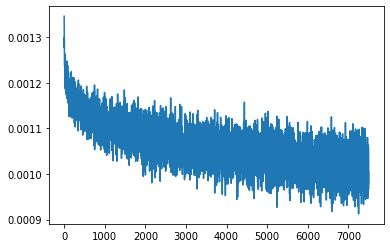

epoch:  5 	 step:0 	 loss: 0.001036
epoch:  5 	 step:100 	 loss: 0.001058
epoch:  5 	 step:200 	 loss: 0.00101
epoch:  5 	 step:300 	 loss: 0.001003
epoch:  5 	 step:400 	 loss: 0.001029
epoch:  5 	 step:500 	 loss: 0.001026
epoch:  5 	 step:600 	 loss: 0.001025
epoch:  5 	 step:700 	 loss: 0.001052
epoch:  5 	 step:800 	 loss: 0.0009231
epoch:  5 	 step:900 	 loss: 0.001008
epoch:  5 	 step:1000 	 loss: 0.001043
epoch:  5 	 step:1100 	 loss: 0.00102
epoch:  5 	 step:1200 	 loss: 0.001007
epoch:  5 	 step:1300 	 loss: 0.0009867
epoch:  5 	 step:1400 	 loss: 0.0009992
epoch:  5 	 step:1500 	 loss: 0.0009803
epoch:  5 	 step:1600 	 loss: 0.0009701
epoch:  5 	 step:1700 	 loss: 0.001027
epoch:  5 	 step:1800 	 loss: 0.001039


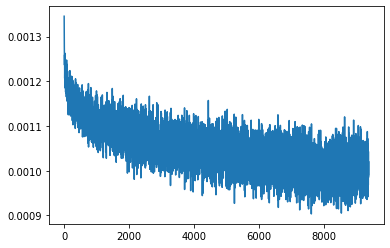

epoch:  6 	 step:0 	 loss: 0.0009507
epoch:  6 	 step:100 	 loss: 0.0009682
epoch:  6 	 step:200 	 loss: 0.0009638
epoch:  6 	 step:300 	 loss: 0.001037
epoch:  6 	 step:400 	 loss: 0.001027
epoch:  6 	 step:500 	 loss: 0.000994
epoch:  6 	 step:600 	 loss: 0.0009952
epoch:  6 	 step:700 	 loss: 0.001002
epoch:  6 	 step:800 	 loss: 0.0009746
epoch:  6 	 step:900 	 loss: 0.001027
epoch:  6 	 step:1000 	 loss: 0.001032
epoch:  6 	 step:1100 	 loss: 0.001002
epoch:  6 	 step:1200 	 loss: 0.0009815
epoch:  6 	 step:1300 	 loss: 0.0009257
epoch:  6 	 step:1400 	 loss: 0.001004
epoch:  6 	 step:1500 	 loss: 0.00105
epoch:  6 	 step:1600 	 loss: 0.0009968
epoch:  6 	 step:1700 	 loss: 0.000969
epoch:  6 	 step:1800 	 loss: 0.0009732


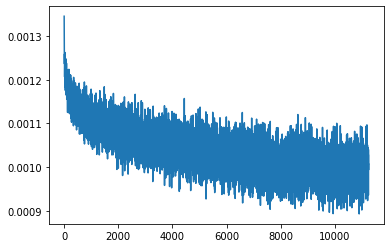

epoch:  7 	 step:0 	 loss: 0.0009595
epoch:  7 	 step:100 	 loss: 0.0009532
epoch:  7 	 step:200 	 loss: 0.0009968
epoch:  7 	 step:300 	 loss: 0.0009903
epoch:  7 	 step:400 	 loss: 0.00101
epoch:  7 	 step:500 	 loss: 0.001007
epoch:  7 	 step:600 	 loss: 0.0009756
epoch:  7 	 step:700 	 loss: 0.0009895
epoch:  7 	 step:800 	 loss: 0.0009408
epoch:  7 	 step:900 	 loss: 0.0009965
epoch:  7 	 step:1000 	 loss: 0.0009524
epoch:  7 	 step:1100 	 loss: 0.001008
epoch:  7 	 step:1200 	 loss: 0.0009705
epoch:  7 	 step:1300 	 loss: 0.001016
epoch:  7 	 step:1400 	 loss: 0.0009536
epoch:  7 	 step:1500 	 loss: 0.001022
epoch:  7 	 step:1600 	 loss: 0.001072
epoch:  7 	 step:1700 	 loss: 0.0009554
epoch:  7 	 step:1800 	 loss: 0.0009165


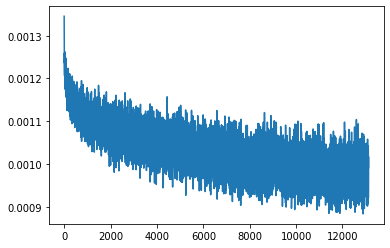

epoch:  8 	 step:0 	 loss: 0.0009319
epoch:  8 	 step:100 	 loss: 0.0009615
epoch:  8 	 step:200 	 loss: 0.0009622
epoch:  8 	 step:300 	 loss: 0.0009689
epoch:  8 	 step:400 	 loss: 0.0009378
epoch:  8 	 step:500 	 loss: 0.001079
epoch:  8 	 step:600 	 loss: 0.0009935
epoch:  8 	 step:700 	 loss: 0.0009712
epoch:  8 	 step:800 	 loss: 0.0009521
epoch:  8 	 step:900 	 loss: 0.0009886
epoch:  8 	 step:1000 	 loss: 0.0009631
epoch:  8 	 step:1100 	 loss: 0.0009834
epoch:  8 	 step:1200 	 loss: 0.0009706
epoch:  8 	 step:1300 	 loss: 0.000976
epoch:  8 	 step:1400 	 loss: 0.001006
epoch:  8 	 step:1500 	 loss: 0.0009487
epoch:  8 	 step:1600 	 loss: 0.0009909
epoch:  8 	 step:1700 	 loss: 0.001008
epoch:  8 	 step:1800 	 loss: 0.001024


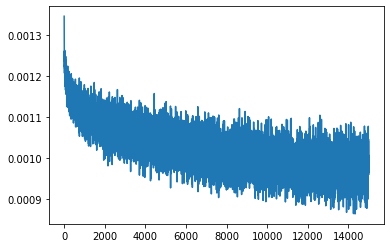

epoch:  9 	 step:0 	 loss: 0.0009256
epoch:  9 	 step:100 	 loss: 0.0009456
epoch:  9 	 step:200 	 loss: 0.0009793
epoch:  9 	 step:300 	 loss: 0.0009338
epoch:  9 	 step:400 	 loss: 0.0009034
epoch:  9 	 step:500 	 loss: 0.001005
epoch:  9 	 step:600 	 loss: 0.0009265
epoch:  9 	 step:700 	 loss: 0.0009234
epoch:  9 	 step:800 	 loss: 0.0009436
epoch:  9 	 step:900 	 loss: 0.0009402
epoch:  9 	 step:1000 	 loss: 0.0009608
epoch:  9 	 step:1100 	 loss: 0.000939
epoch:  9 	 step:1200 	 loss: 0.000958
epoch:  9 	 step:1300 	 loss: 0.0009838
epoch:  9 	 step:1400 	 loss: 0.001008
epoch:  9 	 step:1500 	 loss: 0.0009643
epoch:  9 	 step:1600 	 loss: 0.001009
epoch:  9 	 step:1700 	 loss: 0.0009401
epoch:  9 	 step:1800 	 loss: 0.0009249


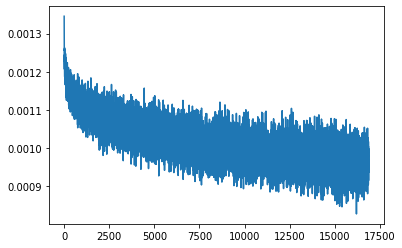

epoch: 10 	 step:0 	 loss: 0.0009422
epoch: 10 	 step:100 	 loss: 0.0009747
epoch: 10 	 step:200 	 loss: 0.0009747
epoch: 10 	 step:300 	 loss: 0.001029
epoch: 10 	 step:400 	 loss: 0.000992
epoch: 10 	 step:500 	 loss: 0.0009412
epoch: 10 	 step:600 	 loss: 0.000944
epoch: 10 	 step:700 	 loss: 0.000948
epoch: 10 	 step:800 	 loss: 0.0009041
epoch: 10 	 step:900 	 loss: 0.0009721
epoch: 10 	 step:1000 	 loss: 0.0009565
epoch: 10 	 step:1100 	 loss: 0.0009605
epoch: 10 	 step:1200 	 loss: 0.0009755
epoch: 10 	 step:1300 	 loss: 0.0009914
epoch: 10 	 step:1400 	 loss: 0.0009166
epoch: 10 	 step:1500 	 loss: 0.0009685
epoch: 10 	 step:1600 	 loss: 0.0009278
epoch: 10 	 step:1700 	 loss: 0.0009559
epoch: 10 	 step:1800 	 loss: 0.0009935


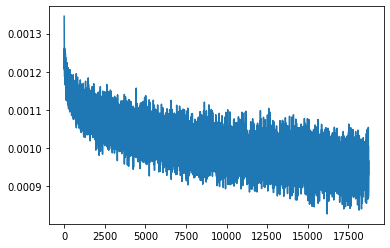

epoch: 11 	 step:0 	 loss: 0.0009551
epoch: 11 	 step:100 	 loss: 0.0009134
epoch: 11 	 step:200 	 loss: 0.0009674
epoch: 11 	 step:300 	 loss: 0.0009039
epoch: 11 	 step:400 	 loss: 0.0009602
epoch: 11 	 step:500 	 loss: 0.0009286
epoch: 11 	 step:600 	 loss: 0.0009537
epoch: 11 	 step:700 	 loss: 0.0009975
epoch: 11 	 step:800 	 loss: 0.0009657
epoch: 11 	 step:900 	 loss: 0.0009083
epoch: 11 	 step:1000 	 loss: 0.0009649
epoch: 11 	 step:1100 	 loss: 0.0009504
epoch: 11 	 step:1200 	 loss: 0.0008721
epoch: 11 	 step:1300 	 loss: 0.0009386
epoch: 11 	 step:1400 	 loss: 0.0009546
epoch: 11 	 step:1500 	 loss: 0.001002
epoch: 11 	 step:1600 	 loss: 0.0009365
epoch: 11 	 step:1700 	 loss: 0.0009549
epoch: 11 	 step:1800 	 loss: 0.00097


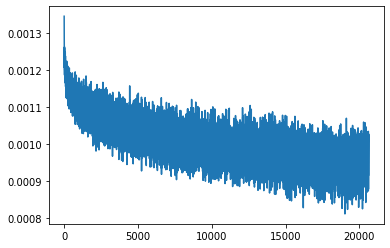

epoch: 12 	 step:0 	 loss: 0.001015
epoch: 12 	 step:100 	 loss: 0.0009208
epoch: 12 	 step:200 	 loss: 0.0009227
epoch: 12 	 step:300 	 loss: 0.0009325
epoch: 12 	 step:400 	 loss: 0.0009593
epoch: 12 	 step:500 	 loss: 0.0009524
epoch: 12 	 step:600 	 loss: 0.0009751
epoch: 12 	 step:700 	 loss: 0.0009405
epoch: 12 	 step:800 	 loss: 0.0008718
epoch: 12 	 step:900 	 loss: 0.0008858
epoch: 12 	 step:1000 	 loss: 0.0009319
epoch: 12 	 step:1100 	 loss: 0.000963
epoch: 12 	 step:1200 	 loss: 0.0009127
epoch: 12 	 step:1300 	 loss: 0.0008636
epoch: 12 	 step:1400 	 loss: 0.0009418
epoch: 12 	 step:1500 	 loss: 0.0008932
epoch: 12 	 step:1600 	 loss: 0.0009065
epoch: 12 	 step:1700 	 loss: 0.0009195
epoch: 12 	 step:1800 	 loss: 0.0009256


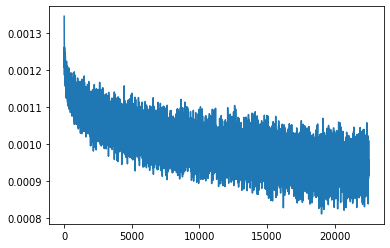

epoch: 13 	 step:0 	 loss: 0.0009197
epoch: 13 	 step:100 	 loss: 0.0008371
epoch: 13 	 step:200 	 loss: 0.0009521
epoch: 13 	 step:300 	 loss: 0.0009372
epoch: 13 	 step:400 	 loss: 0.0009017
epoch: 13 	 step:500 	 loss: 0.000892
epoch: 13 	 step:600 	 loss: 0.0009206
epoch: 13 	 step:700 	 loss: 0.0009031
epoch: 13 	 step:800 	 loss: 0.0009282
epoch: 13 	 step:900 	 loss: 0.0009426
epoch: 13 	 step:1000 	 loss: 0.0009185
epoch: 13 	 step:1100 	 loss: 0.000945
epoch: 13 	 step:1200 	 loss: 0.001052
epoch: 13 	 step:1300 	 loss: 0.0008711
epoch: 13 	 step:1400 	 loss: 0.0009317
epoch: 13 	 step:1500 	 loss: 0.0008728
epoch: 13 	 step:1600 	 loss: 0.0009629
epoch: 13 	 step:1700 	 loss: 0.0008998
epoch: 13 	 step:1800 	 loss: 0.0009262


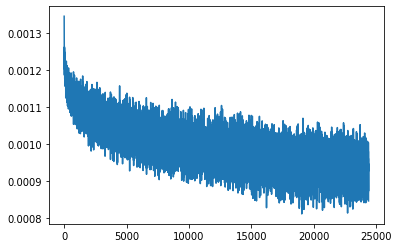

epoch: 14 	 step:0 	 loss: 0.0008698
epoch: 14 	 step:100 	 loss: 0.001002
epoch: 14 	 step:200 	 loss: 0.0009599
epoch: 14 	 step:300 	 loss: 0.0009972
epoch: 14 	 step:400 	 loss: 0.0009747
epoch: 14 	 step:500 	 loss: 0.000983
epoch: 14 	 step:600 	 loss: 0.0009142
epoch: 14 	 step:700 	 loss: 0.0008957
epoch: 14 	 step:800 	 loss: 0.0008964
epoch: 14 	 step:900 	 loss: 0.0009953
epoch: 14 	 step:1000 	 loss: 0.0009381
epoch: 14 	 step:1100 	 loss: 0.0009027
epoch: 14 	 step:1200 	 loss: 0.0009031
epoch: 14 	 step:1300 	 loss: 0.0009257
epoch: 14 	 step:1400 	 loss: 0.0009452
epoch: 14 	 step:1500 	 loss: 0.0009936
epoch: 14 	 step:1600 	 loss: 0.0008581
epoch: 14 	 step:1700 	 loss: 0.0008791
epoch: 14 	 step:1800 	 loss: 0.0009472


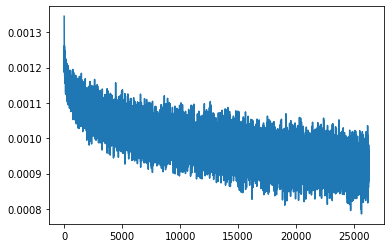

epoch: 15 	 step:0 	 loss: 0.0009772
epoch: 15 	 step:100 	 loss: 0.0008989
epoch: 15 	 step:200 	 loss: 0.00092
epoch: 15 	 step:300 	 loss: 0.0009035
epoch: 15 	 step:400 	 loss: 0.0009221
epoch: 15 	 step:500 	 loss: 0.0009032
epoch: 15 	 step:600 	 loss: 0.0009182
epoch: 15 	 step:700 	 loss: 0.0008992
epoch: 15 	 step:800 	 loss: 0.000816
epoch: 15 	 step:900 	 loss: 0.0009427
epoch: 15 	 step:1000 	 loss: 0.0009769
epoch: 15 	 step:1100 	 loss: 0.0009733
epoch: 15 	 step:1200 	 loss: 0.0008696
epoch: 15 	 step:1300 	 loss: 0.0008548
epoch: 15 	 step:1400 	 loss: 0.000914
epoch: 15 	 step:1500 	 loss: 0.0008486
epoch: 15 	 step:1600 	 loss: 0.0009154
epoch: 15 	 step:1700 	 loss: 0.0009138
epoch: 15 	 step:1800 	 loss: 0.00088


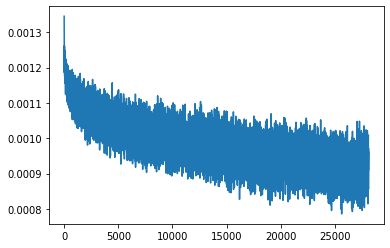

epoch: 16 	 step:0 	 loss: 0.000898
epoch: 16 	 step:100 	 loss: 0.0009098
epoch: 16 	 step:200 	 loss: 0.000921
epoch: 16 	 step:300 	 loss: 0.0008601
epoch: 16 	 step:400 	 loss: 0.000819
epoch: 16 	 step:500 	 loss: 0.0008718
epoch: 16 	 step:600 	 loss: 0.0009165
epoch: 16 	 step:700 	 loss: 0.0008526
epoch: 16 	 step:800 	 loss: 0.0009547
epoch: 16 	 step:900 	 loss: 0.0008775
epoch: 16 	 step:1000 	 loss: 0.0009161
epoch: 16 	 step:1100 	 loss: 0.0009995
epoch: 16 	 step:1200 	 loss: 0.0009624
epoch: 16 	 step:1300 	 loss: 0.0009211
epoch: 16 	 step:1400 	 loss: 0.0009386
epoch: 16 	 step:1500 	 loss: 0.000939
epoch: 16 	 step:1600 	 loss: 0.0008504
epoch: 16 	 step:1700 	 loss: 0.0009946
epoch: 16 	 step:1800 	 loss: 0.0009526


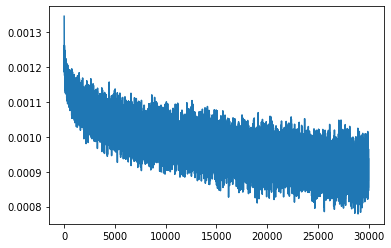

epoch: 17 	 step:0 	 loss: 0.0008659
epoch: 17 	 step:100 	 loss: 0.0009485
epoch: 17 	 step:200 	 loss: 0.0008463
epoch: 17 	 step:300 	 loss: 0.0008918
epoch: 17 	 step:400 	 loss: 0.0008714
epoch: 17 	 step:500 	 loss: 0.0008653
epoch: 17 	 step:600 	 loss: 0.0009404
epoch: 17 	 step:700 	 loss: 0.0008654
epoch: 17 	 step:800 	 loss: 0.0009163
epoch: 17 	 step:900 	 loss: 0.0009358
epoch: 17 	 step:1000 	 loss: 0.0009123
epoch: 17 	 step:1100 	 loss: 0.0009507
epoch: 17 	 step:1200 	 loss: 0.0009065
epoch: 17 	 step:1300 	 loss: 0.0008813
epoch: 17 	 step:1400 	 loss: 0.0008752
epoch: 17 	 step:1500 	 loss: 0.0008684
epoch: 17 	 step:1600 	 loss: 0.0008891
epoch: 17 	 step:1700 	 loss: 0.0009007
epoch: 17 	 step:1800 	 loss: 0.0009506


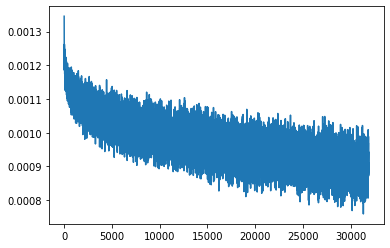

epoch: 18 	 step:0 	 loss: 0.0009006
epoch: 18 	 step:100 	 loss: 0.0008866
epoch: 18 	 step:200 	 loss: 0.0008771
epoch: 18 	 step:300 	 loss: 0.0008608
epoch: 18 	 step:400 	 loss: 0.0009166
epoch: 18 	 step:500 	 loss: 0.000912
epoch: 18 	 step:600 	 loss: 0.0009073
epoch: 18 	 step:700 	 loss: 0.0009344
epoch: 18 	 step:800 	 loss: 0.0008712
epoch: 18 	 step:900 	 loss: 0.0008972
epoch: 18 	 step:1000 	 loss: 0.0008673
epoch: 18 	 step:1100 	 loss: 0.0009403
epoch: 18 	 step:1200 	 loss: 0.0008712
epoch: 18 	 step:1300 	 loss: 0.0008811
epoch: 18 	 step:1400 	 loss: 0.0008801
epoch: 18 	 step:1500 	 loss: 0.000864
epoch: 18 	 step:1600 	 loss: 0.0008954
epoch: 18 	 step:1700 	 loss: 0.0008707
epoch: 18 	 step:1800 	 loss: 0.0008813


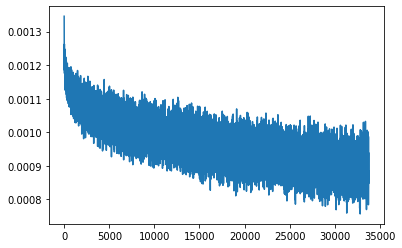

epoch: 19 	 step:0 	 loss: 0.0008071
epoch: 19 	 step:100 	 loss: 0.0008103
epoch: 19 	 step:200 	 loss: 0.0008352
epoch: 19 	 step:300 	 loss: 0.0009103
epoch: 19 	 step:400 	 loss: 0.0008535
epoch: 19 	 step:500 	 loss: 0.0008606
epoch: 19 	 step:600 	 loss: 0.0009233
epoch: 19 	 step:700 	 loss: 0.0009121
epoch: 19 	 step:800 	 loss: 0.0009214
epoch: 19 	 step:900 	 loss: 0.0008768
epoch: 19 	 step:1000 	 loss: 0.000851
epoch: 19 	 step:1100 	 loss: 0.0008481
epoch: 19 	 step:1200 	 loss: 0.0008609
epoch: 19 	 step:1300 	 loss: 0.0008672
epoch: 19 	 step:1400 	 loss: 0.0008719
epoch: 19 	 step:1500 	 loss: 0.000861
epoch: 19 	 step:1600 	 loss: 0.000916
epoch: 19 	 step:1700 	 loss: 0.0009204
epoch: 19 	 step:1800 	 loss: 0.0008546


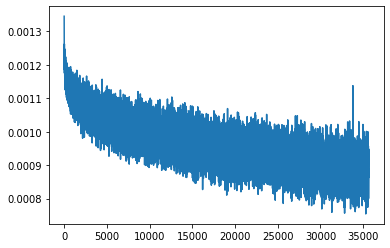

epoch: 20 	 step:0 	 loss: 0.0008442
epoch: 20 	 step:100 	 loss: 0.0008715
epoch: 20 	 step:200 	 loss: 0.0008355
epoch: 20 	 step:300 	 loss: 0.0008943
epoch: 20 	 step:400 	 loss: 0.0009068
epoch: 20 	 step:500 	 loss: 0.0008983
epoch: 20 	 step:600 	 loss: 0.0008387
epoch: 20 	 step:700 	 loss: 0.000837
epoch: 20 	 step:800 	 loss: 0.0008638
epoch: 20 	 step:900 	 loss: 0.0008724
epoch: 20 	 step:1000 	 loss: 0.0009069
epoch: 20 	 step:1100 	 loss: 0.0009237
epoch: 20 	 step:1200 	 loss: 0.0009082
epoch: 20 	 step:1300 	 loss: 0.00083
epoch: 20 	 step:1400 	 loss: 0.0009113
epoch: 20 	 step:1500 	 loss: 0.0008806
epoch: 20 	 step:1600 	 loss: 0.0008086
epoch: 20 	 step:1700 	 loss: 0.0009223
epoch: 20 	 step:1800 	 loss: 0.0008644


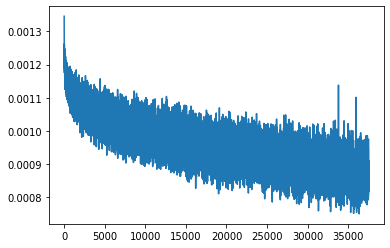

epoch: 21 	 step:0 	 loss: 0.0008454
epoch: 21 	 step:100 	 loss: 0.0008023
epoch: 21 	 step:200 	 loss: 0.0009263
epoch: 21 	 step:300 	 loss: 0.0008374
epoch: 21 	 step:400 	 loss: 0.0008967
epoch: 21 	 step:500 	 loss: 0.000842
epoch: 21 	 step:600 	 loss: 0.0008602
epoch: 21 	 step:700 	 loss: 0.0008454
epoch: 21 	 step:800 	 loss: 0.0009068
epoch: 21 	 step:900 	 loss: 0.0008715
epoch: 21 	 step:1000 	 loss: 0.0008349
epoch: 21 	 step:1100 	 loss: 0.0008816
epoch: 21 	 step:1200 	 loss: 0.0008579
epoch: 21 	 step:1300 	 loss: 0.0008673
epoch: 21 	 step:1400 	 loss: 0.0009379
epoch: 21 	 step:1500 	 loss: 0.0009036
epoch: 21 	 step:1600 	 loss: 0.0008097
epoch: 21 	 step:1700 	 loss: 0.000914
epoch: 21 	 step:1800 	 loss: 0.0008828


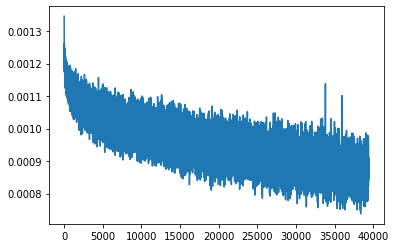

epoch: 22 	 step:0 	 loss: 0.0008235
epoch: 22 	 step:100 	 loss: 0.0008732
epoch: 22 	 step:200 	 loss: 0.0007967
epoch: 22 	 step:300 	 loss: 0.0008343
epoch: 22 	 step:400 	 loss: 0.0008181
epoch: 22 	 step:500 	 loss: 0.00088
epoch: 22 	 step:600 	 loss: 0.0008538
epoch: 22 	 step:700 	 loss: 0.0008845
epoch: 22 	 step:800 	 loss: 0.0008939
epoch: 22 	 step:900 	 loss: 0.0008707
epoch: 22 	 step:1000 	 loss: 0.0008583
epoch: 22 	 step:1100 	 loss: 0.000905
epoch: 22 	 step:1200 	 loss: 0.0008369
epoch: 22 	 step:1300 	 loss: 0.0009409
epoch: 22 	 step:1400 	 loss: 0.0008174
epoch: 22 	 step:1500 	 loss: 0.0009373
epoch: 22 	 step:1600 	 loss: 0.0007987
epoch: 22 	 step:1700 	 loss: 0.0009385
epoch: 22 	 step:1800 	 loss: 0.0008942


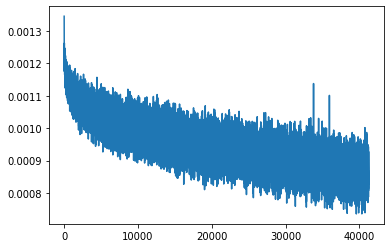

epoch: 23 	 step:0 	 loss: 0.0008449
epoch: 23 	 step:100 	 loss: 0.0009086
epoch: 23 	 step:200 	 loss: 0.0008773
epoch: 23 	 step:300 	 loss: 0.0007993
epoch: 23 	 step:400 	 loss: 0.0008498
epoch: 23 	 step:500 	 loss: 0.0008544
epoch: 23 	 step:600 	 loss: 0.0008612
epoch: 23 	 step:700 	 loss: 0.0009084
epoch: 23 	 step:800 	 loss: 0.0009074
epoch: 23 	 step:900 	 loss: 0.0008328
epoch: 23 	 step:1000 	 loss: 0.0008829
epoch: 23 	 step:1100 	 loss: 0.0008995
epoch: 23 	 step:1200 	 loss: 0.0009374
epoch: 23 	 step:1300 	 loss: 0.000812
epoch: 23 	 step:1400 	 loss: 0.0009295
epoch: 23 	 step:1500 	 loss: 0.0009047
epoch: 23 	 step:1600 	 loss: 0.0008344
epoch: 23 	 step:1700 	 loss: 0.0008547
epoch: 23 	 step:1800 	 loss: 0.0009329


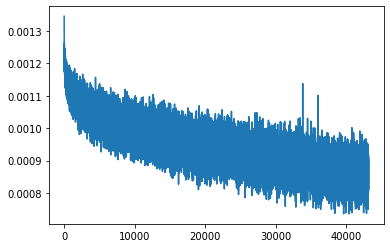

epoch: 24 	 step:0 	 loss: 0.0008102
epoch: 24 	 step:100 	 loss: 0.0008233
epoch: 24 	 step:200 	 loss: 0.0008008
epoch: 24 	 step:300 	 loss: 0.0008098
epoch: 24 	 step:400 	 loss: 0.0007972
epoch: 24 	 step:500 	 loss: 0.0009117
epoch: 24 	 step:600 	 loss: 0.0008794
epoch: 24 	 step:700 	 loss: 0.0008285
epoch: 24 	 step:800 	 loss: 0.0008472
epoch: 24 	 step:900 	 loss: 0.0008699
epoch: 24 	 step:1000 	 loss: 0.0009112
epoch: 24 	 step:1100 	 loss: 0.0008616
epoch: 24 	 step:1200 	 loss: 0.0008728
epoch: 24 	 step:1300 	 loss: 0.0008301
epoch: 24 	 step:1400 	 loss: 0.0008181
epoch: 24 	 step:1500 	 loss: 0.0008044
epoch: 24 	 step:1600 	 loss: 0.0008709
epoch: 24 	 step:1700 	 loss: 0.0009094
epoch: 24 	 step:1800 	 loss: 0.0008698


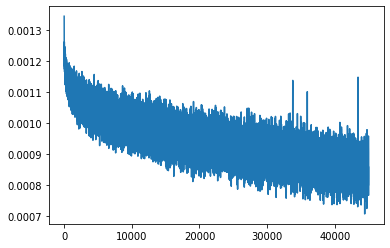

epoch: 25 	 step:0 	 loss: 0.0008682
epoch: 25 	 step:100 	 loss: 0.0008189
epoch: 25 	 step:200 	 loss: 0.0007337
epoch: 25 	 step:300 	 loss: 0.000848
epoch: 25 	 step:400 	 loss: 0.0008408
epoch: 25 	 step:500 	 loss: 0.0007814
epoch: 25 	 step:600 	 loss: 0.0008775
epoch: 25 	 step:700 	 loss: 0.0008363
epoch: 25 	 step:800 	 loss: 0.0008144
epoch: 25 	 step:900 	 loss: 0.0008454
epoch: 25 	 step:1000 	 loss: 0.0008315
epoch: 25 	 step:1100 	 loss: 0.0008764
epoch: 25 	 step:1200 	 loss: 0.0008198
epoch: 25 	 step:1300 	 loss: 0.0008445
epoch: 25 	 step:1400 	 loss: 0.0009096
epoch: 25 	 step:1500 	 loss: 0.0008955
epoch: 25 	 step:1600 	 loss: 0.0008422
epoch: 25 	 step:1700 	 loss: 0.0008307
epoch: 25 	 step:1800 	 loss: 0.0008419


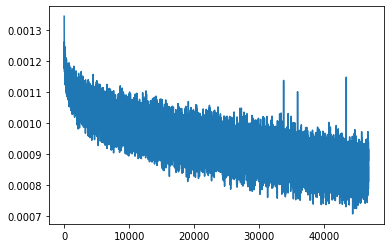

epoch: 26 	 step:0 	 loss: 0.0008348
epoch: 26 	 step:100 	 loss: 0.0008119
epoch: 26 	 step:200 	 loss: 0.0008074
epoch: 26 	 step:300 	 loss: 0.0007841
epoch: 26 	 step:400 	 loss: 0.0008563
epoch: 26 	 step:500 	 loss: 0.0008386
epoch: 26 	 step:600 	 loss: 0.0008763
epoch: 26 	 step:700 	 loss: 0.0008179
epoch: 26 	 step:800 	 loss: 0.0007836
epoch: 26 	 step:900 	 loss: 0.0008092
epoch: 26 	 step:1000 	 loss: 0.0008111
epoch: 26 	 step:1100 	 loss: 0.0008362
epoch: 26 	 step:1200 	 loss: 0.0008303
epoch: 26 	 step:1300 	 loss: 0.0009322
epoch: 26 	 step:1400 	 loss: 0.0008896
epoch: 26 	 step:1500 	 loss: 0.0008863
epoch: 26 	 step:1600 	 loss: 0.0008512
epoch: 26 	 step:1700 	 loss: 0.0009262
epoch: 26 	 step:1800 	 loss: 0.0009111


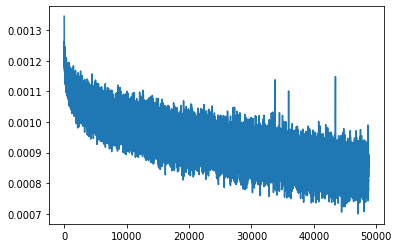

epoch: 27 	 step:0 	 loss: 0.000863
epoch: 27 	 step:100 	 loss: 0.0008284
epoch: 27 	 step:200 	 loss: 0.0008179
epoch: 27 	 step:300 	 loss: 0.000815
epoch: 27 	 step:400 	 loss: 0.0008161
epoch: 27 	 step:500 	 loss: 0.0008946
epoch: 27 	 step:600 	 loss: 0.0008436
epoch: 27 	 step:700 	 loss: 0.0008844
epoch: 27 	 step:800 	 loss: 0.0008421
epoch: 27 	 step:900 	 loss: 0.0008726
epoch: 27 	 step:1000 	 loss: 0.0008366
epoch: 27 	 step:1100 	 loss: 0.0008522
epoch: 27 	 step:1200 	 loss: 0.0008206
epoch: 27 	 step:1300 	 loss: 0.0008221
epoch: 27 	 step:1400 	 loss: 0.0008036
epoch: 27 	 step:1500 	 loss: 0.0008515
epoch: 27 	 step:1600 	 loss: 0.0007983
epoch: 27 	 step:1700 	 loss: 0.0008799
epoch: 27 	 step:1800 	 loss: 0.0008848


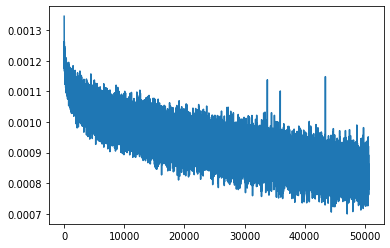

epoch: 28 	 step:0 	 loss: 0.0008404
epoch: 28 	 step:100 	 loss: 0.0008582
epoch: 28 	 step:200 	 loss: 0.0008276
epoch: 28 	 step:300 	 loss: 0.0008161
epoch: 28 	 step:400 	 loss: 0.0008205
epoch: 28 	 step:500 	 loss: 0.0008451
epoch: 28 	 step:600 	 loss: 0.0008857
epoch: 28 	 step:700 	 loss: 0.0008365
epoch: 28 	 step:800 	 loss: 0.0008286
epoch: 28 	 step:900 	 loss: 0.0008839
epoch: 28 	 step:1000 	 loss: 0.0008492
epoch: 28 	 step:1100 	 loss: 0.0008281
epoch: 28 	 step:1200 	 loss: 0.0008372
epoch: 28 	 step:1300 	 loss: 0.0008743
epoch: 28 	 step:1400 	 loss: 0.0007678
epoch: 28 	 step:1500 	 loss: 0.000819
epoch: 28 	 step:1600 	 loss: 0.0007522
epoch: 28 	 step:1700 	 loss: 0.0008452
epoch: 28 	 step:1800 	 loss: 0.000908


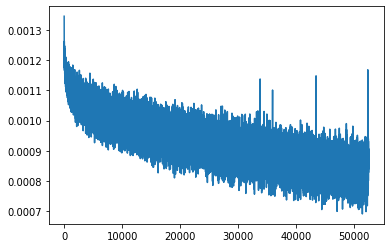

epoch: 29 	 step:0 	 loss: 0.0007988
epoch: 29 	 step:100 	 loss: 0.0008091
epoch: 29 	 step:200 	 loss: 0.0008482
epoch: 29 	 step:300 	 loss: 0.0008092
epoch: 29 	 step:400 	 loss: 0.0008139
epoch: 29 	 step:500 	 loss: 0.000824
epoch: 29 	 step:600 	 loss: 0.000885
epoch: 29 	 step:700 	 loss: 0.0007652
epoch: 29 	 step:800 	 loss: 0.0008896
epoch: 29 	 step:900 	 loss: 0.0007935
epoch: 29 	 step:1000 	 loss: 0.000793
epoch: 29 	 step:1100 	 loss: 0.0008327
epoch: 29 	 step:1200 	 loss: 0.0008113
epoch: 29 	 step:1300 	 loss: 0.0007895
epoch: 29 	 step:1400 	 loss: 0.0008615
epoch: 29 	 step:1500 	 loss: 0.0008219
epoch: 29 	 step:1600 	 loss: 0.0007957
epoch: 29 	 step:1700 	 loss: 0.0008341
epoch: 29 	 step:1800 	 loss: 0.0008139


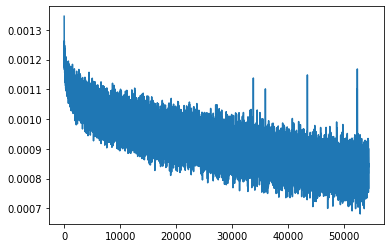

epoch: 30 	 step:0 	 loss: 0.0008467
epoch: 30 	 step:100 	 loss: 0.0007615
epoch: 30 	 step:200 	 loss: 0.0007767
epoch: 30 	 step:300 	 loss: 0.0008122
epoch: 30 	 step:400 	 loss: 0.000757
epoch: 30 	 step:500 	 loss: 0.0008325
epoch: 30 	 step:600 	 loss: 0.0007745
epoch: 30 	 step:700 	 loss: 0.0008856
epoch: 30 	 step:800 	 loss: 0.0008072
epoch: 30 	 step:900 	 loss: 0.0008188
epoch: 30 	 step:1000 	 loss: 0.000828
epoch: 30 	 step:1100 	 loss: 0.0008259
epoch: 30 	 step:1200 	 loss: 0.000788
epoch: 30 	 step:1300 	 loss: 0.0008033
epoch: 30 	 step:1400 	 loss: 0.0007879
epoch: 30 	 step:1500 	 loss: 0.0008314
epoch: 30 	 step:1600 	 loss: 0.0008616
epoch: 30 	 step:1700 	 loss: 0.0008351
epoch: 30 	 step:1800 	 loss: 0.0008329


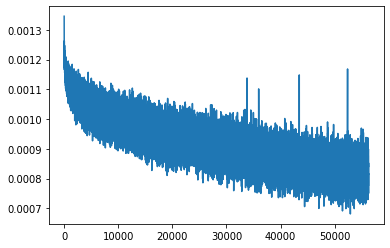

epoch: 31 	 step:0 	 loss: 0.0007512
epoch: 31 	 step:100 	 loss: 0.0007655
epoch: 31 	 step:200 	 loss: 0.0008535
epoch: 31 	 step:300 	 loss: 0.0007756
epoch: 31 	 step:400 	 loss: 0.0007771
epoch: 31 	 step:500 	 loss: 0.0007911
epoch: 31 	 step:600 	 loss: 0.000808
epoch: 31 	 step:700 	 loss: 0.0008071
epoch: 31 	 step:800 	 loss: 0.0007687
epoch: 31 	 step:900 	 loss: 0.0008388
epoch: 31 	 step:1000 	 loss: 0.0008221
epoch: 31 	 step:1100 	 loss: 0.0008257
epoch: 31 	 step:1200 	 loss: 0.0009035
epoch: 31 	 step:1300 	 loss: 0.0008393
epoch: 31 	 step:1400 	 loss: 0.0007943
epoch: 31 	 step:1500 	 loss: 0.0008112
epoch: 31 	 step:1600 	 loss: 0.000772
epoch: 31 	 step:1700 	 loss: 0.0008191
epoch: 31 	 step:1800 	 loss: 0.0008129


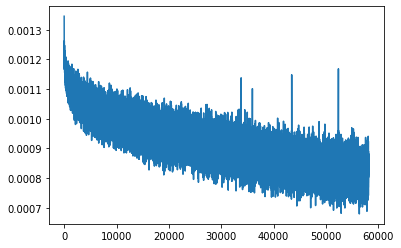

epoch: 32 	 step:0 	 loss: 0.0007581
epoch: 32 	 step:100 	 loss: 0.0007583
epoch: 32 	 step:200 	 loss: 0.0007984
epoch: 32 	 step:300 	 loss: 0.0007916
epoch: 32 	 step:400 	 loss: 0.0008348
epoch: 32 	 step:500 	 loss: 0.0007783
epoch: 32 	 step:600 	 loss: 0.000767
epoch: 32 	 step:700 	 loss: 0.0008127
epoch: 32 	 step:800 	 loss: 0.0007785
epoch: 32 	 step:900 	 loss: 0.0007811
epoch: 32 	 step:1000 	 loss: 0.0007452
epoch: 32 	 step:1100 	 loss: 0.0007577
epoch: 32 	 step:1200 	 loss: 0.000811
epoch: 32 	 step:1300 	 loss: 0.0008243
epoch: 32 	 step:1400 	 loss: 0.0008027
epoch: 32 	 step:1500 	 loss: 0.000843
epoch: 32 	 step:1600 	 loss: 0.0007906
epoch: 32 	 step:1700 	 loss: 0.0008779
epoch: 32 	 step:1800 	 loss: 0.0008254


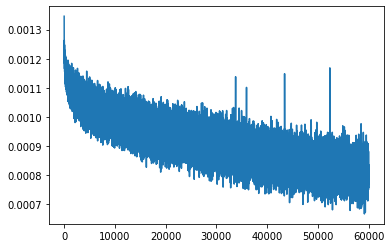

epoch: 33 	 step:0 	 loss: 0.0007919
epoch: 33 	 step:100 	 loss: 0.0007734
epoch: 33 	 step:200 	 loss: 0.0007378
epoch: 33 	 step:300 	 loss: 0.0008193
epoch: 33 	 step:400 	 loss: 0.0007543
epoch: 33 	 step:500 	 loss: 0.0007777
epoch: 33 	 step:600 	 loss: 0.0008592
epoch: 33 	 step:700 	 loss: 0.0007411
epoch: 33 	 step:800 	 loss: 0.0007379
epoch: 33 	 step:900 	 loss: 0.0008233
epoch: 33 	 step:1000 	 loss: 0.0007653
epoch: 33 	 step:1100 	 loss: 0.0008456
epoch: 33 	 step:1200 	 loss: 0.0007878
epoch: 33 	 step:1300 	 loss: 0.0008652
epoch: 33 	 step:1400 	 loss: 0.0008082
epoch: 33 	 step:1500 	 loss: 0.0008327
epoch: 33 	 step:1600 	 loss: 0.0008378
epoch: 33 	 step:1700 	 loss: 0.0007804
epoch: 33 	 step:1800 	 loss: 0.0007847


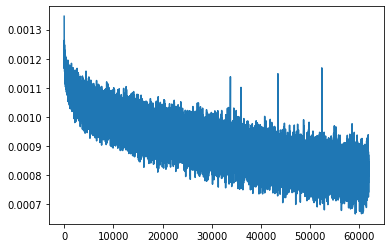

epoch: 34 	 step:0 	 loss: 0.0007387
epoch: 34 	 step:100 	 loss: 0.0007404
epoch: 34 	 step:200 	 loss: 0.0008806
epoch: 34 	 step:300 	 loss: 0.0007961
epoch: 34 	 step:400 	 loss: 0.0008192
epoch: 34 	 step:500 	 loss: 0.0008207
epoch: 34 	 step:600 	 loss: 0.0007601
epoch: 34 	 step:700 	 loss: 0.0008167
epoch: 34 	 step:800 	 loss: 0.0008462
epoch: 34 	 step:900 	 loss: 0.0008433
epoch: 34 	 step:1000 	 loss: 0.0007772
epoch: 34 	 step:1100 	 loss: 0.00076
epoch: 34 	 step:1200 	 loss: 0.0008283
epoch: 34 	 step:1300 	 loss: 0.0008509
epoch: 34 	 step:1400 	 loss: 0.0008362
epoch: 34 	 step:1500 	 loss: 0.0008557
epoch: 34 	 step:1600 	 loss: 0.0008289
epoch: 34 	 step:1700 	 loss: 0.0007569
epoch: 34 	 step:1800 	 loss: 0.0008418


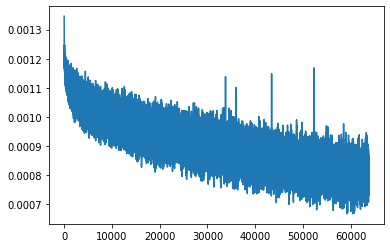

epoch: 35 	 step:0 	 loss: 0.0007917
epoch: 35 	 step:100 	 loss: 0.0008089
epoch: 35 	 step:200 	 loss: 0.0007264
epoch: 35 	 step:300 	 loss: 0.0007769
epoch: 35 	 step:400 	 loss: 0.0008912
epoch: 35 	 step:500 	 loss: 0.0007868
epoch: 35 	 step:600 	 loss: 0.0008669
epoch: 35 	 step:700 	 loss: 0.0008409
epoch: 35 	 step:800 	 loss: 0.0007554
epoch: 35 	 step:900 	 loss: 0.0008351
epoch: 35 	 step:1000 	 loss: 0.0007775
epoch: 35 	 step:1100 	 loss: 0.000803
epoch: 35 	 step:1200 	 loss: 0.0008305
epoch: 35 	 step:1300 	 loss: 0.000842
epoch: 35 	 step:1400 	 loss: 0.000804
epoch: 35 	 step:1500 	 loss: 0.0008057
epoch: 35 	 step:1600 	 loss: 0.0007868
epoch: 35 	 step:1700 	 loss: 0.0008334
epoch: 35 	 step:1800 	 loss: 0.0007812


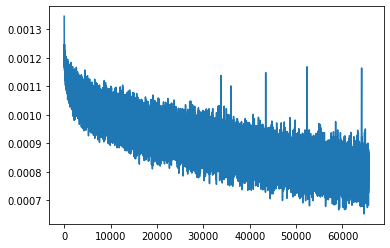

epoch: 36 	 step:0 	 loss: 0.0008249
epoch: 36 	 step:100 	 loss: 0.000801
epoch: 36 	 step:200 	 loss: 0.0007873
epoch: 36 	 step:300 	 loss: 0.0008377
epoch: 36 	 step:400 	 loss: 0.000816
epoch: 36 	 step:500 	 loss: 0.0008393
epoch: 36 	 step:600 	 loss: 0.0008339
epoch: 36 	 step:700 	 loss: 0.0008312
epoch: 36 	 step:800 	 loss: 0.0007803
epoch: 36 	 step:900 	 loss: 0.0008143
epoch: 36 	 step:1000 	 loss: 0.0008282
epoch: 36 	 step:1100 	 loss: 0.0007811
epoch: 36 	 step:1200 	 loss: 0.0008937
epoch: 36 	 step:1300 	 loss: 0.0007433
epoch: 36 	 step:1400 	 loss: 0.0008584
epoch: 36 	 step:1500 	 loss: 0.0008187
epoch: 36 	 step:1600 	 loss: 0.0008549
epoch: 36 	 step:1700 	 loss: 0.0007469
epoch: 36 	 step:1800 	 loss: 0.0008082


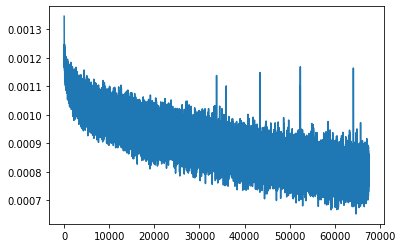

epoch: 37 	 step:0 	 loss: 0.0007319
epoch: 37 	 step:100 	 loss: 0.0007184
epoch: 37 	 step:200 	 loss: 0.0007694
epoch: 37 	 step:300 	 loss: 0.0008074
epoch: 37 	 step:400 	 loss: 0.000737
epoch: 37 	 step:500 	 loss: 0.0007823
epoch: 37 	 step:600 	 loss: 0.0006862
epoch: 37 	 step:700 	 loss: 0.0007838
epoch: 37 	 step:800 	 loss: 0.0007741
epoch: 37 	 step:900 	 loss: 0.0007332
epoch: 37 	 step:1000 	 loss: 0.0008087
epoch: 37 	 step:1100 	 loss: 0.00067
epoch: 37 	 step:1200 	 loss: 0.0007725
epoch: 37 	 step:1300 	 loss: 0.0007464
epoch: 37 	 step:1400 	 loss: 0.0007552
epoch: 37 	 step:1500 	 loss: 0.0007523
epoch: 37 	 step:1600 	 loss: 0.0008365
epoch: 37 	 step:1700 	 loss: 0.0008016
epoch: 37 	 step:1800 	 loss: 0.0008002


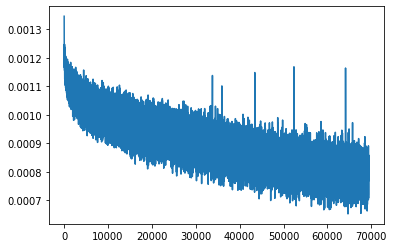

epoch: 38 	 step:0 	 loss: 0.000843
epoch: 38 	 step:100 	 loss: 0.0007446
epoch: 38 	 step:200 	 loss: 0.0007505
epoch: 38 	 step:300 	 loss: 0.0007322
epoch: 38 	 step:400 	 loss: 0.0007395
epoch: 38 	 step:500 	 loss: 0.0007323
epoch: 38 	 step:600 	 loss: 0.0008064
epoch: 38 	 step:700 	 loss: 0.0007972
epoch: 38 	 step:800 	 loss: 0.0007442
epoch: 38 	 step:900 	 loss: 0.0007129
epoch: 38 	 step:1000 	 loss: 0.0007656
epoch: 38 	 step:1100 	 loss: 0.0007221
epoch: 38 	 step:1200 	 loss: 0.0007931
epoch: 38 	 step:1300 	 loss: 0.0008166
epoch: 38 	 step:1400 	 loss: 0.0008354
epoch: 38 	 step:1500 	 loss: 0.0007849
epoch: 38 	 step:1600 	 loss: 0.000804
epoch: 38 	 step:1700 	 loss: 0.0008445
epoch: 38 	 step:1800 	 loss: 0.000811


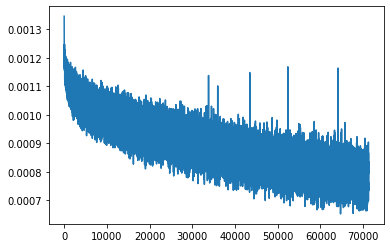

epoch: 39 	 step:0 	 loss: 0.0007162
epoch: 39 	 step:100 	 loss: 0.0006982
epoch: 39 	 step:200 	 loss: 0.0007683
epoch: 39 	 step:300 	 loss: 0.000822
epoch: 39 	 step:400 	 loss: 0.0008447
epoch: 39 	 step:500 	 loss: 0.0007776
epoch: 39 	 step:600 	 loss: 0.0007287
epoch: 39 	 step:700 	 loss: 0.0008043
epoch: 39 	 step:800 	 loss: 0.0007359
epoch: 39 	 step:900 	 loss: 0.0007768
epoch: 39 	 step:1000 	 loss: 0.0007586
epoch: 39 	 step:1100 	 loss: 0.0007933
epoch: 39 	 step:1200 	 loss: 0.000749
epoch: 39 	 step:1300 	 loss: 0.0008498
epoch: 39 	 step:1400 	 loss: 0.0007291
epoch: 39 	 step:1500 	 loss: 0.0007634
epoch: 39 	 step:1600 	 loss: 0.0007827
epoch: 39 	 step:1700 	 loss: 0.0007946
epoch: 39 	 step:1800 	 loss: 0.0008618


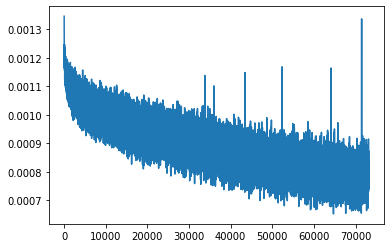

epoch: 40 	 step:0 	 loss: 0.0007703
epoch: 40 	 step:100 	 loss: 0.0006373
epoch: 40 	 step:200 	 loss: 0.0007404
epoch: 40 	 step:300 	 loss: 0.0007069
epoch: 40 	 step:400 	 loss: 0.0006982
epoch: 40 	 step:500 	 loss: 0.0008169
epoch: 40 	 step:600 	 loss: 0.0007829
epoch: 40 	 step:700 	 loss: 0.0007435
epoch: 40 	 step:800 	 loss: 0.0008234
epoch: 40 	 step:900 	 loss: 0.0006527
epoch: 40 	 step:1000 	 loss: 0.0008244
epoch: 40 	 step:1100 	 loss: 0.0007581
epoch: 40 	 step:1200 	 loss: 0.0007961
epoch: 40 	 step:1300 	 loss: 0.0007534
epoch: 40 	 step:1400 	 loss: 0.0008098
epoch: 40 	 step:1500 	 loss: 0.0008252
epoch: 40 	 step:1600 	 loss: 0.0007776
epoch: 40 	 step:1700 	 loss: 0.0008053
epoch: 40 	 step:1800 	 loss: 0.0008052


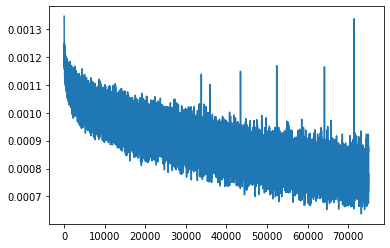

epoch: 41 	 step:0 	 loss: 0.0007985
epoch: 41 	 step:100 	 loss: 0.0007583
epoch: 41 	 step:200 	 loss: 0.0007193
epoch: 41 	 step:300 	 loss: 0.0007325
epoch: 41 	 step:400 	 loss: 0.0007508
epoch: 41 	 step:500 	 loss: 0.0007191
epoch: 41 	 step:600 	 loss: 0.000801
epoch: 41 	 step:700 	 loss: 0.0007314
epoch: 41 	 step:800 	 loss: 0.0007812
epoch: 41 	 step:900 	 loss: 0.0007457
epoch: 41 	 step:1000 	 loss: 0.0008937
epoch: 41 	 step:1100 	 loss: 0.0007802
epoch: 41 	 step:1200 	 loss: 0.0007348
epoch: 41 	 step:1300 	 loss: 0.000787
epoch: 41 	 step:1400 	 loss: 0.0008245
epoch: 41 	 step:1500 	 loss: 0.0008356
epoch: 41 	 step:1600 	 loss: 0.0007518
epoch: 41 	 step:1700 	 loss: 0.0007671
epoch: 41 	 step:1800 	 loss: 0.0007186


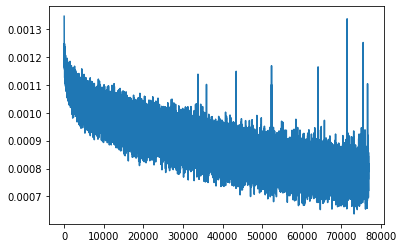

epoch: 42 	 step:0 	 loss: 0.0007208
epoch: 42 	 step:100 	 loss: 0.0007849
epoch: 42 	 step:200 	 loss: 0.0007494
epoch: 42 	 step:300 	 loss: 0.0007652
epoch: 42 	 step:400 	 loss: 0.0007803
epoch: 42 	 step:500 	 loss: 0.000737
epoch: 42 	 step:600 	 loss: 0.000816
epoch: 42 	 step:700 	 loss: 0.0007394
epoch: 42 	 step:800 	 loss: 0.0007465
epoch: 42 	 step:900 	 loss: 0.0007281
epoch: 42 	 step:1000 	 loss: 0.0007684
epoch: 42 	 step:1100 	 loss: 0.0008308
epoch: 42 	 step:1200 	 loss: 0.0007605
epoch: 42 	 step:1300 	 loss: 0.0008032
epoch: 42 	 step:1400 	 loss: 0.0008543
epoch: 42 	 step:1500 	 loss: 0.0007833
epoch: 42 	 step:1600 	 loss: 0.0007529
epoch: 42 	 step:1700 	 loss: 0.0007627
epoch: 42 	 step:1800 	 loss: 0.0007151


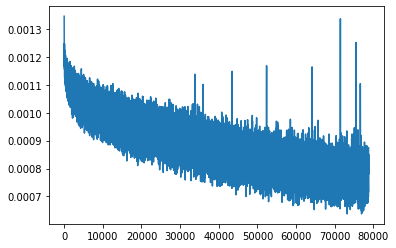

epoch: 43 	 step:0 	 loss: 0.0007115
epoch: 43 	 step:100 	 loss: 0.0007182
epoch: 43 	 step:200 	 loss: 0.0008318
epoch: 43 	 step:300 	 loss: 0.0007861
epoch: 43 	 step:400 	 loss: 0.0007516
epoch: 43 	 step:500 	 loss: 0.0007898
epoch: 43 	 step:600 	 loss: 0.0007804
epoch: 43 	 step:700 	 loss: 0.0008314
epoch: 43 	 step:800 	 loss: 0.0007003
epoch: 43 	 step:900 	 loss: 0.000758
epoch: 43 	 step:1000 	 loss: 0.0008233
epoch: 43 	 step:1100 	 loss: 0.001393
epoch: 43 	 step:1200 	 loss: 0.0007488
epoch: 43 	 step:1300 	 loss: 0.0007652
epoch: 43 	 step:1400 	 loss: 0.0008222
epoch: 43 	 step:1500 	 loss: 0.0007738
epoch: 43 	 step:1600 	 loss: 0.0008567
epoch: 43 	 step:1700 	 loss: 0.0007945
epoch: 43 	 step:1800 	 loss: 0.00077


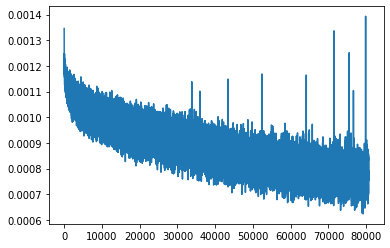

epoch: 44 	 step:0 	 loss: 0.0007315
epoch: 44 	 step:100 	 loss: 0.0007543
epoch: 44 	 step:200 	 loss: 0.0007197
epoch: 44 	 step:300 	 loss: 0.0007696
epoch: 44 	 step:400 	 loss: 0.0007096
epoch: 44 	 step:500 	 loss: 0.0007572
epoch: 44 	 step:600 	 loss: 0.0007598
epoch: 44 	 step:700 	 loss: 0.0007503
epoch: 44 	 step:800 	 loss: 0.0007424
epoch: 44 	 step:900 	 loss: 0.0008154
epoch: 44 	 step:1000 	 loss: 0.0007837
epoch: 44 	 step:1100 	 loss: 0.0007556
epoch: 44 	 step:1200 	 loss: 0.0007371
epoch: 44 	 step:1300 	 loss: 0.0008574
epoch: 44 	 step:1400 	 loss: 0.0006864
epoch: 44 	 step:1500 	 loss: 0.0007787
epoch: 44 	 step:1600 	 loss: 0.0007446
epoch: 44 	 step:1700 	 loss: 0.0007836
epoch: 44 	 step:1800 	 loss: 0.0007548


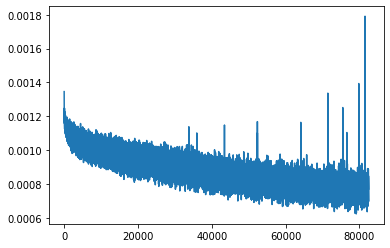

epoch: 45 	 step:0 	 loss: 0.0007398
epoch: 45 	 step:100 	 loss: 0.0007597
epoch: 45 	 step:200 	 loss: 0.0007767
epoch: 45 	 step:300 	 loss: 0.0008066
epoch: 45 	 step:400 	 loss: 0.0007393
epoch: 45 	 step:500 	 loss: 0.0008129
epoch: 45 	 step:600 	 loss: 0.0007215
epoch: 45 	 step:700 	 loss: 0.0007356
epoch: 45 	 step:800 	 loss: 0.0007187
epoch: 45 	 step:900 	 loss: 0.000752
epoch: 45 	 step:1000 	 loss: 0.0007109
epoch: 45 	 step:1100 	 loss: 0.0007237
epoch: 45 	 step:1200 	 loss: 0.0008099
epoch: 45 	 step:1300 	 loss: 0.0006941
epoch: 45 	 step:1400 	 loss: 0.0007881
epoch: 45 	 step:1500 	 loss: 0.0008157
epoch: 45 	 step:1600 	 loss: 0.0007736
epoch: 45 	 step:1700 	 loss: 0.0007564
epoch: 45 	 step:1800 	 loss: 0.0007598


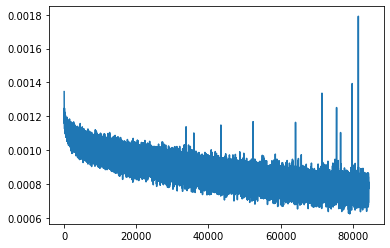

epoch: 46 	 step:0 	 loss: 0.0007332
epoch: 46 	 step:100 	 loss: 0.000757
epoch: 46 	 step:200 	 loss: 0.0007507
epoch: 46 	 step:300 	 loss: 0.0007421
epoch: 46 	 step:400 	 loss: 0.0007662
epoch: 46 	 step:500 	 loss: 0.0007365
epoch: 46 	 step:600 	 loss: 0.0007514
epoch: 46 	 step:700 	 loss: 0.0007739
epoch: 46 	 step:800 	 loss: 0.0007659
epoch: 46 	 step:900 	 loss: 0.0007275
epoch: 46 	 step:1000 	 loss: 0.0007424
epoch: 46 	 step:1100 	 loss: 0.0007923
epoch: 46 	 step:1200 	 loss: 0.0007473
epoch: 46 	 step:1300 	 loss: 0.000723
epoch: 46 	 step:1400 	 loss: 0.0007557
epoch: 46 	 step:1500 	 loss: 0.0006795
epoch: 46 	 step:1600 	 loss: 0.0006913
epoch: 46 	 step:1700 	 loss: 0.0007212
epoch: 46 	 step:1800 	 loss: 0.0007869


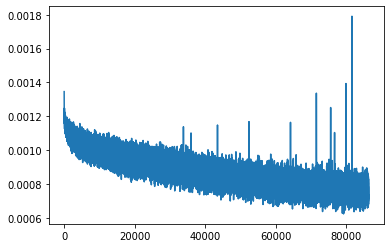

epoch: 47 	 step:0 	 loss: 0.0007614
epoch: 47 	 step:100 	 loss: 0.0007579
epoch: 47 	 step:200 	 loss: 0.00073
epoch: 47 	 step:300 	 loss: 0.0007393
epoch: 47 	 step:400 	 loss: 0.0007615
epoch: 47 	 step:500 	 loss: 0.0008094
epoch: 47 	 step:600 	 loss: 0.00077
epoch: 47 	 step:700 	 loss: 0.0007706
epoch: 47 	 step:800 	 loss: 0.0007738
epoch: 47 	 step:900 	 loss: 0.0007857
epoch: 47 	 step:1000 	 loss: 0.0006648
epoch: 47 	 step:1100 	 loss: 0.000671
epoch: 47 	 step:1200 	 loss: 0.0007643
epoch: 47 	 step:1300 	 loss: 0.0007916
epoch: 47 	 step:1400 	 loss: 0.0007502
epoch: 47 	 step:1500 	 loss: 0.0007755
epoch: 47 	 step:1600 	 loss: 0.0007831
epoch: 47 	 step:1700 	 loss: 0.0007135
epoch: 47 	 step:1800 	 loss: 0.0006923


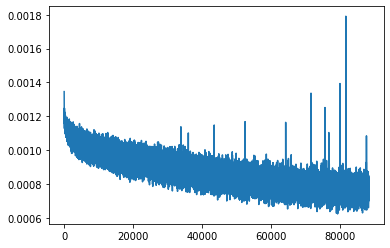

epoch: 48 	 step:0 	 loss: 0.0007158
epoch: 48 	 step:100 	 loss: 0.0007843
epoch: 48 	 step:200 	 loss: 0.0007229
epoch: 48 	 step:300 	 loss: 0.0007031
epoch: 48 	 step:400 	 loss: 0.000755
epoch: 48 	 step:500 	 loss: 0.0007882
epoch: 48 	 step:600 	 loss: 0.0007475
epoch: 48 	 step:700 	 loss: 0.0007422
epoch: 48 	 step:800 	 loss: 0.0007925
epoch: 48 	 step:900 	 loss: 0.0007697
epoch: 48 	 step:1000 	 loss: 0.0007786
epoch: 48 	 step:1100 	 loss: 0.0007671
epoch: 48 	 step:1200 	 loss: 0.0007993
epoch: 48 	 step:1300 	 loss: 0.0007836
epoch: 48 	 step:1400 	 loss: 0.0007636
epoch: 48 	 step:1500 	 loss: 0.0007306
epoch: 48 	 step:1600 	 loss: 0.0007169
epoch: 48 	 step:1700 	 loss: 0.0008131
epoch: 48 	 step:1800 	 loss: 0.0007276


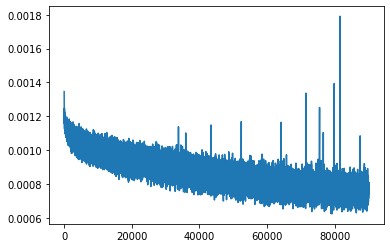

epoch: 49 	 step:0 	 loss: 0.0007471
epoch: 49 	 step:100 	 loss: 0.0007252
epoch: 49 	 step:200 	 loss: 0.0007997
epoch: 49 	 step:300 	 loss: 0.0007082
epoch: 49 	 step:400 	 loss: 0.0007084
epoch: 49 	 step:500 	 loss: 0.0007077
epoch: 49 	 step:600 	 loss: 0.0006947
epoch: 49 	 step:700 	 loss: 0.0007575
epoch: 49 	 step:800 	 loss: 0.0007136
epoch: 49 	 step:900 	 loss: 0.000736
epoch: 49 	 step:1000 	 loss: 0.0007533
epoch: 49 	 step:1100 	 loss: 0.0006929
epoch: 49 	 step:1200 	 loss: 0.0008197
epoch: 49 	 step:1300 	 loss: 0.0007124
epoch: 49 	 step:1400 	 loss: 0.0007227
epoch: 49 	 step:1500 	 loss: 0.0007796
epoch: 49 	 step:1600 	 loss: 0.0007685
epoch: 49 	 step:1700 	 loss: 0.0007603
epoch: 49 	 step:1800 	 loss: 0.0008278


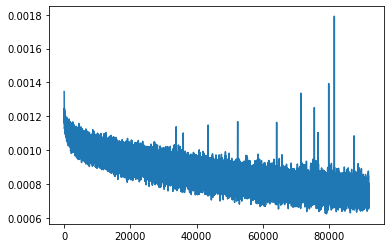

epoch: 50 	 step:0 	 loss: 0.0007165
epoch: 50 	 step:100 	 loss: 0.0007623
epoch: 50 	 step:200 	 loss: 0.0007303
epoch: 50 	 step:300 	 loss: 0.0007131
epoch: 50 	 step:400 	 loss: 0.0007407
epoch: 50 	 step:500 	 loss: 0.0007009
epoch: 50 	 step:600 	 loss: 0.0006468
epoch: 50 	 step:700 	 loss: 0.0007375
epoch: 50 	 step:800 	 loss: 0.0007974
epoch: 50 	 step:900 	 loss: 0.0006704
epoch: 50 	 step:1000 	 loss: 0.0007073
epoch: 50 	 step:1100 	 loss: 0.0007536
epoch: 50 	 step:1200 	 loss: 0.0007868
epoch: 50 	 step:1300 	 loss: 0.0008006
epoch: 50 	 step:1400 	 loss: 0.0007028
epoch: 50 	 step:1500 	 loss: 0.0006671
epoch: 50 	 step:1600 	 loss: 0.000718
epoch: 50 	 step:1700 	 loss: 0.0007528
epoch: 50 	 step:1800 	 loss: 0.0008032


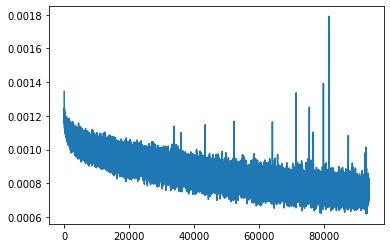

epoch: 51 	 step:0 	 loss: 0.0007335
epoch: 51 	 step:100 	 loss: 0.0007794
epoch: 51 	 step:200 	 loss: 0.0006956
epoch: 51 	 step:300 	 loss: 0.0007335
epoch: 51 	 step:400 	 loss: 0.0006764
epoch: 51 	 step:500 	 loss: 0.0007296
epoch: 51 	 step:600 	 loss: 0.0007714
epoch: 51 	 step:700 	 loss: 0.0007448
epoch: 51 	 step:800 	 loss: 0.0006936
epoch: 51 	 step:900 	 loss: 0.0007349
epoch: 51 	 step:1000 	 loss: 0.0007296
epoch: 51 	 step:1100 	 loss: 0.0007471
epoch: 51 	 step:1200 	 loss: 0.0008184
epoch: 51 	 step:1300 	 loss: 0.0006934
epoch: 51 	 step:1400 	 loss: 0.0008144
epoch: 51 	 step:1500 	 loss: 0.0007917
epoch: 51 	 step:1600 	 loss: 0.0007701
epoch: 51 	 step:1700 	 loss: 0.0007281
epoch: 51 	 step:1800 	 loss: 0.0007333


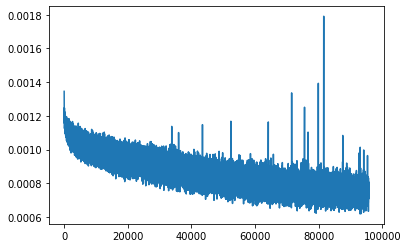

epoch: 52 	 step:0 	 loss: 0.0007404
epoch: 52 	 step:100 	 loss: 0.0007529
epoch: 52 	 step:200 	 loss: 0.000756
epoch: 52 	 step:300 	 loss: 0.0007615
epoch: 52 	 step:400 	 loss: 0.0007409
epoch: 52 	 step:500 	 loss: 0.0007245
epoch: 52 	 step:600 	 loss: 0.0007717
epoch: 52 	 step:700 	 loss: 0.0006781
epoch: 52 	 step:800 	 loss: 0.0007792
epoch: 52 	 step:900 	 loss: 0.000765
epoch: 52 	 step:1000 	 loss: 0.0007199
epoch: 52 	 step:1100 	 loss: 0.0007317
epoch: 52 	 step:1200 	 loss: 0.0007226
epoch: 52 	 step:1300 	 loss: 0.0007423
epoch: 52 	 step:1400 	 loss: 0.0007756
epoch: 52 	 step:1500 	 loss: 0.0006833
epoch: 52 	 step:1600 	 loss: 0.0007537
epoch: 52 	 step:1700 	 loss: 0.0008209
epoch: 52 	 step:1800 	 loss: 0.0006975


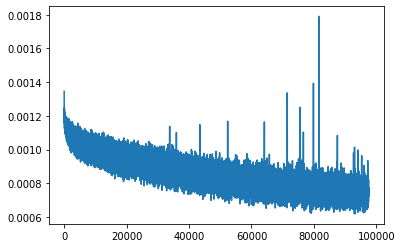

epoch: 53 	 step:0 	 loss: 0.0007587
epoch: 53 	 step:100 	 loss: 0.0006955
epoch: 53 	 step:200 	 loss: 0.0006886
epoch: 53 	 step:300 	 loss: 0.0007764
epoch: 53 	 step:400 	 loss: 0.000701
epoch: 53 	 step:500 	 loss: 0.0007333
epoch: 53 	 step:600 	 loss: 0.0006731
epoch: 53 	 step:700 	 loss: 0.0007334
epoch: 53 	 step:800 	 loss: 0.0007568
epoch: 53 	 step:900 	 loss: 0.0007347
epoch: 53 	 step:1000 	 loss: 0.0007814
epoch: 53 	 step:1100 	 loss: 0.000725
epoch: 53 	 step:1200 	 loss: 0.0007898
epoch: 53 	 step:1300 	 loss: 0.0006261
epoch: 53 	 step:1400 	 loss: 0.0007766
epoch: 53 	 step:1500 	 loss: 0.0007331
epoch: 53 	 step:1600 	 loss: 0.0007455
epoch: 53 	 step:1700 	 loss: 0.000712
epoch: 53 	 step:1800 	 loss: 0.000717


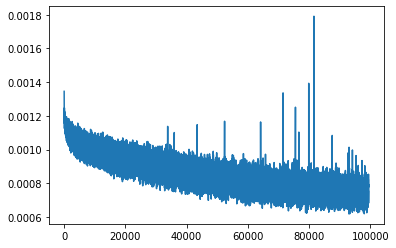

epoch: 54 	 step:0 	 loss: 0.0007616
epoch: 54 	 step:100 	 loss: 0.0007063
epoch: 54 	 step:200 	 loss: 0.000736
epoch: 54 	 step:300 	 loss: 0.0007724
epoch: 54 	 step:400 	 loss: 0.0006828
epoch: 54 	 step:500 	 loss: 0.0007022
epoch: 54 	 step:600 	 loss: 0.000776
epoch: 54 	 step:700 	 loss: 0.0007641
epoch: 54 	 step:800 	 loss: 0.0007436
epoch: 54 	 step:900 	 loss: 0.0007392
epoch: 54 	 step:1000 	 loss: 0.0007475
epoch: 54 	 step:1100 	 loss: 0.0007495
epoch: 54 	 step:1200 	 loss: 0.000706
epoch: 54 	 step:1300 	 loss: 0.0007491
epoch: 54 	 step:1400 	 loss: 0.000751
epoch: 54 	 step:1500 	 loss: 0.0007498
epoch: 54 	 step:1600 	 loss: 0.000801
epoch: 54 	 step:1700 	 loss: 0.000714
epoch: 54 	 step:1800 	 loss: 0.000791


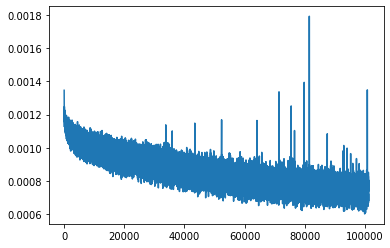

epoch: 55 	 step:0 	 loss: 0.0007048
epoch: 55 	 step:100 	 loss: 0.000596
epoch: 55 	 step:200 	 loss: 0.000689
epoch: 55 	 step:300 	 loss: 0.0007544
epoch: 55 	 step:400 	 loss: 0.0007135
epoch: 55 	 step:500 	 loss: 0.0006692
epoch: 55 	 step:600 	 loss: 0.0006872
epoch: 55 	 step:700 	 loss: 0.0007937
epoch: 55 	 step:800 	 loss: 0.0007398
epoch: 55 	 step:900 	 loss: 0.0007318
epoch: 55 	 step:1000 	 loss: 0.000694
epoch: 55 	 step:1100 	 loss: 0.000719
epoch: 55 	 step:1200 	 loss: 0.0007134
epoch: 55 	 step:1300 	 loss: 0.0007756
epoch: 55 	 step:1400 	 loss: 0.0007754
epoch: 55 	 step:1500 	 loss: 0.0007505
epoch: 55 	 step:1600 	 loss: 0.0007145
epoch: 55 	 step:1700 	 loss: 0.000726
epoch: 55 	 step:1800 	 loss: 0.0007349


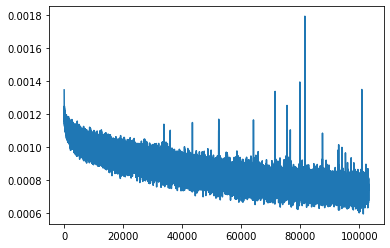

epoch: 56 	 step:0 	 loss: 0.0007337
epoch: 56 	 step:100 	 loss: 0.0007042
epoch: 56 	 step:200 	 loss: 0.0007815
epoch: 56 	 step:300 	 loss: 0.0006554
epoch: 56 	 step:400 	 loss: 0.0007188
epoch: 56 	 step:500 	 loss: 0.0007439
epoch: 56 	 step:600 	 loss: 0.0007486
epoch: 56 	 step:700 	 loss: 0.000768
epoch: 56 	 step:800 	 loss: 0.0006939
epoch: 56 	 step:900 	 loss: 0.0007608
epoch: 56 	 step:1000 	 loss: 0.000781
epoch: 56 	 step:1100 	 loss: 0.0007532
epoch: 56 	 step:1200 	 loss: 0.0007011
epoch: 56 	 step:1300 	 loss: 0.0007367
epoch: 56 	 step:1400 	 loss: 0.0007576
epoch: 56 	 step:1500 	 loss: 0.0007731
epoch: 56 	 step:1600 	 loss: 0.0007335
epoch: 56 	 step:1700 	 loss: 0.0007279
epoch: 56 	 step:1800 	 loss: 0.0007751


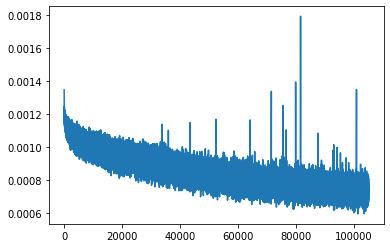

epoch: 57 	 step:0 	 loss: 0.0007492
epoch: 57 	 step:100 	 loss: 0.0007689
epoch: 57 	 step:200 	 loss: 0.0007225
epoch: 57 	 step:300 	 loss: 0.0006425
epoch: 57 	 step:400 	 loss: 0.0007346
epoch: 57 	 step:500 	 loss: 0.0007399
epoch: 57 	 step:600 	 loss: 0.0007415
epoch: 57 	 step:700 	 loss: 0.0007613
epoch: 57 	 step:800 	 loss: 0.0006644
epoch: 57 	 step:900 	 loss: 0.0007437
epoch: 57 	 step:1000 	 loss: 0.0007268
epoch: 57 	 step:1100 	 loss: 0.0007071
epoch: 57 	 step:1200 	 loss: 0.0007835
epoch: 57 	 step:1300 	 loss: 0.0007103
epoch: 57 	 step:1400 	 loss: 0.0006737
epoch: 57 	 step:1500 	 loss: 0.0008051
epoch: 57 	 step:1600 	 loss: 0.0008002
epoch: 57 	 step:1700 	 loss: 0.0007716
epoch: 57 	 step:1800 	 loss: 0.000738


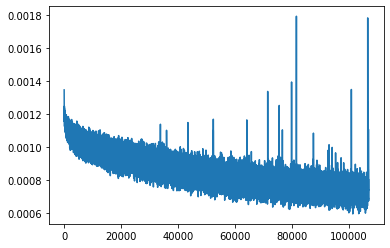

epoch: 58 	 step:0 	 loss: 0.000736
epoch: 58 	 step:100 	 loss: 0.0006978
epoch: 58 	 step:200 	 loss: 0.0007743
epoch: 58 	 step:300 	 loss: 0.0007154
epoch: 58 	 step:400 	 loss: 0.000723
epoch: 58 	 step:500 	 loss: 0.0007418
epoch: 58 	 step:600 	 loss: 0.0007908
epoch: 58 	 step:700 	 loss: 0.000732
epoch: 58 	 step:800 	 loss: 0.0007959
epoch: 58 	 step:900 	 loss: 0.0006888
epoch: 58 	 step:1000 	 loss: 0.0007529
epoch: 58 	 step:1100 	 loss: 0.0006663
epoch: 58 	 step:1200 	 loss: 0.000756
epoch: 58 	 step:1300 	 loss: 0.0006833
epoch: 58 	 step:1400 	 loss: 0.00073
epoch: 58 	 step:1500 	 loss: 0.0007266
epoch: 58 	 step:1600 	 loss: 0.0007829
epoch: 58 	 step:1700 	 loss: 0.0006733
epoch: 58 	 step:1800 	 loss: 0.0007164


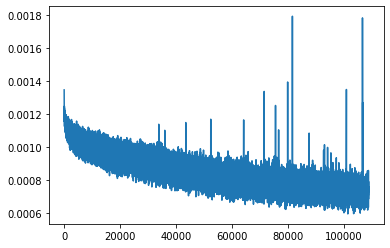

epoch: 59 	 step:0 	 loss: 0.0006593
epoch: 59 	 step:100 	 loss: 0.0007121
epoch: 59 	 step:200 	 loss: 0.0007268
epoch: 59 	 step:300 	 loss: 0.0007135
epoch: 59 	 step:400 	 loss: 0.000718
epoch: 59 	 step:500 	 loss: 0.0007631
epoch: 59 	 step:600 	 loss: 0.0008
epoch: 59 	 step:700 	 loss: 0.0007085
epoch: 59 	 step:800 	 loss: 0.0007303
epoch: 59 	 step:900 	 loss: 0.0007174
epoch: 59 	 step:1000 	 loss: 0.0007433
epoch: 59 	 step:1100 	 loss: 0.0006983
epoch: 59 	 step:1200 	 loss: 0.000743
epoch: 59 	 step:1300 	 loss: 0.0007508
epoch: 59 	 step:1400 	 loss: 0.0006893
epoch: 59 	 step:1500 	 loss: 0.0007607
epoch: 59 	 step:1600 	 loss: 0.0007445
epoch: 59 	 step:1700 	 loss: 0.0006789
epoch: 59 	 step:1800 	 loss: 0.000738


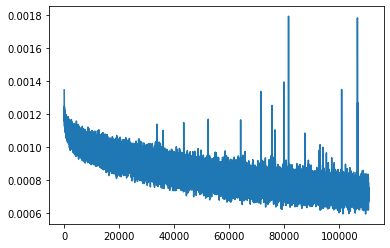

epoch: 60 	 step:0 	 loss: 0.0007276
epoch: 60 	 step:100 	 loss: 0.0006811
epoch: 60 	 step:200 	 loss: 0.0006639
epoch: 60 	 step:300 	 loss: 0.0007235
epoch: 60 	 step:400 	 loss: 0.0007167
epoch: 60 	 step:500 	 loss: 0.0007726
epoch: 60 	 step:600 	 loss: 0.0007008
epoch: 60 	 step:700 	 loss: 0.0006735
epoch: 60 	 step:800 	 loss: 0.0007707
epoch: 60 	 step:900 	 loss: 0.0006842
epoch: 60 	 step:1000 	 loss: 0.0007741
epoch: 60 	 step:1100 	 loss: 0.0007542
epoch: 60 	 step:1200 	 loss: 0.0007639
epoch: 60 	 step:1300 	 loss: 0.0006481
epoch: 60 	 step:1400 	 loss: 0.0006978
epoch: 60 	 step:1500 	 loss: 0.0006846
epoch: 60 	 step:1600 	 loss: 0.0007709
epoch: 60 	 step:1700 	 loss: 0.0006711
epoch: 60 	 step:1800 	 loss: 0.0006848


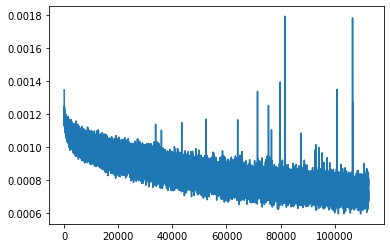

epoch: 61 	 step:0 	 loss: 0.0006904
epoch: 61 	 step:100 	 loss: 0.0006854
epoch: 61 	 step:200 	 loss: 0.0006686
epoch: 61 	 step:300 	 loss: 0.0007099
epoch: 61 	 step:400 	 loss: 0.0007161
epoch: 61 	 step:500 	 loss: 0.0007609
epoch: 61 	 step:600 	 loss: 0.0007173
epoch: 61 	 step:700 	 loss: 0.0006862
epoch: 61 	 step:800 	 loss: 0.0006942
epoch: 61 	 step:900 	 loss: 0.0006785
epoch: 61 	 step:1000 	 loss: 0.0006817
epoch: 61 	 step:1100 	 loss: 0.0006363
epoch: 61 	 step:1200 	 loss: 0.0007396
epoch: 61 	 step:1300 	 loss: 0.0006688
epoch: 61 	 step:1400 	 loss: 0.0007542
epoch: 61 	 step:1500 	 loss: 0.0007471
epoch: 61 	 step:1600 	 loss: 0.0007017
epoch: 61 	 step:1700 	 loss: 0.0007811
epoch: 61 	 step:1800 	 loss: 0.0007507


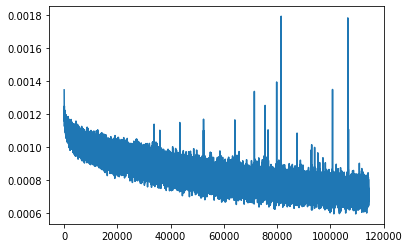

epoch: 62 	 step:0 	 loss: 0.0007678
epoch: 62 	 step:100 	 loss: 0.0006947
epoch: 62 	 step:200 	 loss: 0.0007046
epoch: 62 	 step:300 	 loss: 0.0007305
epoch: 62 	 step:400 	 loss: 0.0007705
epoch: 62 	 step:500 	 loss: 0.0006896
epoch: 62 	 step:600 	 loss: 0.0006726
epoch: 62 	 step:700 	 loss: 0.000668
epoch: 62 	 step:800 	 loss: 0.0007491
epoch: 62 	 step:900 	 loss: 0.0006634
epoch: 62 	 step:1000 	 loss: 0.0007185
epoch: 62 	 step:1100 	 loss: 0.0007312
epoch: 62 	 step:1200 	 loss: 0.0006271
epoch: 62 	 step:1300 	 loss: 0.0007378
epoch: 62 	 step:1400 	 loss: 0.0007512
epoch: 62 	 step:1500 	 loss: 0.0007557
epoch: 62 	 step:1600 	 loss: 0.0007185
epoch: 62 	 step:1700 	 loss: 0.0006949
epoch: 62 	 step:1800 	 loss: 0.0006486


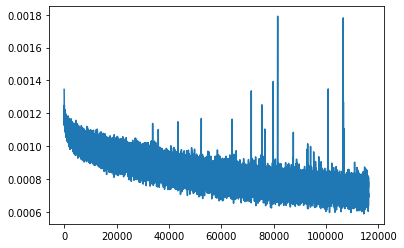

epoch: 63 	 step:0 	 loss: 0.0007645
epoch: 63 	 step:100 	 loss: 0.0007214
epoch: 63 	 step:200 	 loss: 0.0007231
epoch: 63 	 step:300 	 loss: 0.0007144
epoch: 63 	 step:400 	 loss: 0.0007433
epoch: 63 	 step:500 	 loss: 0.0007028
epoch: 63 	 step:600 	 loss: 0.0007573
epoch: 63 	 step:700 	 loss: 0.0006746
epoch: 63 	 step:800 	 loss: 0.0006742
epoch: 63 	 step:900 	 loss: 0.0007168
epoch: 63 	 step:1000 	 loss: 0.0007698
epoch: 63 	 step:1100 	 loss: 0.0007017
epoch: 63 	 step:1200 	 loss: 0.0006835
epoch: 63 	 step:1300 	 loss: 0.0006847
epoch: 63 	 step:1400 	 loss: 0.0006718
epoch: 63 	 step:1500 	 loss: 0.0007001
epoch: 63 	 step:1600 	 loss: 0.0007374
epoch: 63 	 step:1700 	 loss: 0.0007162
epoch: 63 	 step:1800 	 loss: 0.0006834


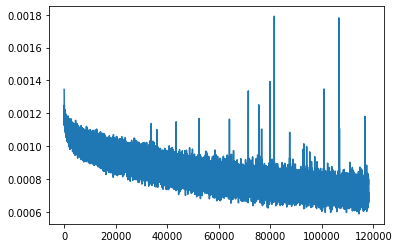

epoch: 64 	 step:0 	 loss: 0.0006725
epoch: 64 	 step:100 	 loss: 0.0006893
epoch: 64 	 step:200 	 loss: 0.0006839
epoch: 64 	 step:300 	 loss: 0.0006982
epoch: 64 	 step:400 	 loss: 0.0007665
epoch: 64 	 step:500 	 loss: 0.0007384
epoch: 64 	 step:600 	 loss: 0.0007297
epoch: 64 	 step:700 	 loss: 0.0006782
epoch: 64 	 step:800 	 loss: 0.0007262
epoch: 64 	 step:900 	 loss: 0.0007323
epoch: 64 	 step:1000 	 loss: 0.0006976
epoch: 64 	 step:1100 	 loss: 0.0007808
epoch: 64 	 step:1200 	 loss: 0.0007503
epoch: 64 	 step:1300 	 loss: 0.0007579
epoch: 64 	 step:1400 	 loss: 0.0006436
epoch: 64 	 step:1500 	 loss: 0.000758
epoch: 64 	 step:1600 	 loss: 0.0006899
epoch: 64 	 step:1700 	 loss: 0.0007092
epoch: 64 	 step:1800 	 loss: 0.0007236


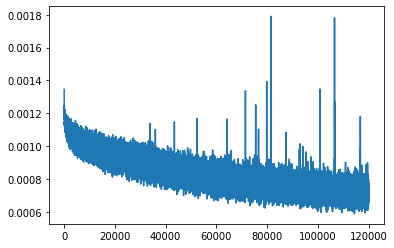

epoch: 65 	 step:0 	 loss: 0.0007233
epoch: 65 	 step:100 	 loss: 0.0006743
epoch: 65 	 step:200 	 loss: 0.0006607
epoch: 65 	 step:300 	 loss: 0.0006746
epoch: 65 	 step:400 	 loss: 0.0007526
epoch: 65 	 step:500 	 loss: 0.0007173
epoch: 65 	 step:600 	 loss: 0.0006825
epoch: 65 	 step:700 	 loss: 0.0007167
epoch: 65 	 step:800 	 loss: 0.0006765
epoch: 65 	 step:900 	 loss: 0.0006899
epoch: 65 	 step:1000 	 loss: 0.0006434
epoch: 65 	 step:1100 	 loss: 0.0006974
epoch: 65 	 step:1200 	 loss: 0.0007713
epoch: 65 	 step:1300 	 loss: 0.0006588
epoch: 65 	 step:1400 	 loss: 0.0008019
epoch: 65 	 step:1500 	 loss: 0.0007501
epoch: 65 	 step:1600 	 loss: 0.0007642
epoch: 65 	 step:1700 	 loss: 0.0006907
epoch: 65 	 step:1800 	 loss: 0.0007415


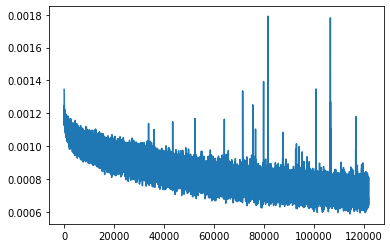

epoch: 66 	 step:0 	 loss: 0.0007685
epoch: 66 	 step:100 	 loss: 0.0006318
epoch: 66 	 step:200 	 loss: 0.0007543
epoch: 66 	 step:300 	 loss: 0.0006301
epoch: 66 	 step:400 	 loss: 0.0007024
epoch: 66 	 step:500 	 loss: 0.0006875
epoch: 66 	 step:600 	 loss: 0.0007128
epoch: 66 	 step:700 	 loss: 0.0006974
epoch: 66 	 step:800 	 loss: 0.0007017
epoch: 66 	 step:900 	 loss: 0.0006863
epoch: 66 	 step:1000 	 loss: 0.0006817
epoch: 66 	 step:1100 	 loss: 0.0006759
epoch: 66 	 step:1200 	 loss: 0.0007047
epoch: 66 	 step:1300 	 loss: 0.0007084
epoch: 66 	 step:1400 	 loss: 0.0006339
epoch: 66 	 step:1500 	 loss: 0.0007526
epoch: 66 	 step:1600 	 loss: 0.0007164
epoch: 66 	 step:1700 	 loss: 0.0007581
epoch: 66 	 step:1800 	 loss: 0.0007593


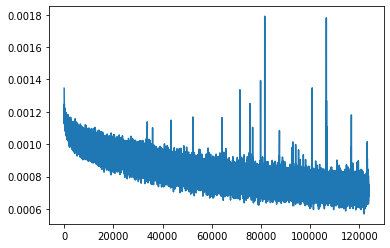

epoch: 67 	 step:0 	 loss: 0.0007271
epoch: 67 	 step:100 	 loss: 0.0007143
epoch: 67 	 step:200 	 loss: 0.0006879
epoch: 67 	 step:300 	 loss: 0.0008264
epoch: 67 	 step:400 	 loss: 0.0007113
epoch: 67 	 step:500 	 loss: 0.0006892
epoch: 67 	 step:600 	 loss: 0.0007605
epoch: 67 	 step:700 	 loss: 0.0006999
epoch: 67 	 step:800 	 loss: 0.0006911
epoch: 67 	 step:900 	 loss: 0.0007242
epoch: 67 	 step:1000 	 loss: 0.0007454
epoch: 67 	 step:1100 	 loss: 0.0006782
epoch: 67 	 step:1200 	 loss: 0.0006872
epoch: 67 	 step:1300 	 loss: 0.0007789
epoch: 67 	 step:1400 	 loss: 0.0007062
epoch: 67 	 step:1500 	 loss: 0.0007201
epoch: 67 	 step:1600 	 loss: 0.0006585
epoch: 67 	 step:1700 	 loss: 0.0007234
epoch: 67 	 step:1800 	 loss: 0.0007104


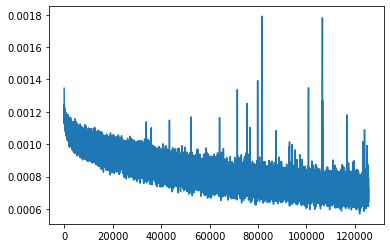

epoch: 68 	 step:0 	 loss: 0.0007031
epoch: 68 	 step:100 	 loss: 0.0006855
epoch: 68 	 step:200 	 loss: 0.0006995
epoch: 68 	 step:300 	 loss: 0.000678
epoch: 68 	 step:400 	 loss: 0.0008064
epoch: 68 	 step:500 	 loss: 0.0006785
epoch: 68 	 step:600 	 loss: 0.0006412
epoch: 68 	 step:700 	 loss: 0.000702
epoch: 68 	 step:800 	 loss: 0.0007119
epoch: 68 	 step:900 	 loss: 0.0006774
epoch: 68 	 step:1000 	 loss: 0.0006991
epoch: 68 	 step:1100 	 loss: 0.0007062
epoch: 68 	 step:1200 	 loss: 0.0006446
epoch: 68 	 step:1300 	 loss: 0.000669
epoch: 68 	 step:1400 	 loss: 0.0007395
epoch: 68 	 step:1500 	 loss: 0.0007014
epoch: 68 	 step:1600 	 loss: 0.000684
epoch: 68 	 step:1700 	 loss: 0.0007202
epoch: 68 	 step:1800 	 loss: 0.0007108


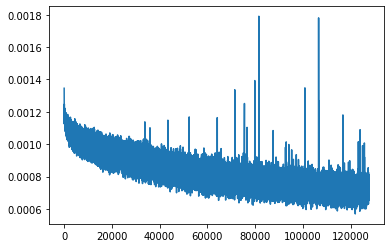

epoch: 69 	 step:0 	 loss: 0.0006574
epoch: 69 	 step:100 	 loss: 0.0007489
epoch: 69 	 step:200 	 loss: 0.0006749
epoch: 69 	 step:300 	 loss: 0.0007405
epoch: 69 	 step:400 	 loss: 0.0007173
epoch: 69 	 step:500 	 loss: 0.0007594
epoch: 69 	 step:600 	 loss: 0.0007261
epoch: 69 	 step:700 	 loss: 0.0007099
epoch: 69 	 step:800 	 loss: 0.0007117
epoch: 69 	 step:900 	 loss: 0.0007274
epoch: 69 	 step:1000 	 loss: 0.0006642
epoch: 69 	 step:1100 	 loss: 0.0007496
epoch: 69 	 step:1200 	 loss: 0.0006873
epoch: 69 	 step:1300 	 loss: 0.0007279
epoch: 69 	 step:1400 	 loss: 0.0006926
epoch: 69 	 step:1500 	 loss: 0.000753
epoch: 69 	 step:1600 	 loss: 0.0007358
epoch: 69 	 step:1700 	 loss: 0.000682
epoch: 69 	 step:1800 	 loss: 0.0006938


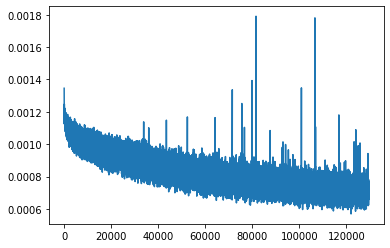

epoch: 70 	 step:0 	 loss: 0.0006829
epoch: 70 	 step:100 	 loss: 0.0007284
epoch: 70 	 step:200 	 loss: 0.0007044
epoch: 70 	 step:300 	 loss: 0.0007488
epoch: 70 	 step:400 	 loss: 0.0006768
epoch: 70 	 step:500 	 loss: 0.0006525
epoch: 70 	 step:600 	 loss: 0.0007395
epoch: 70 	 step:700 	 loss: 0.0006462
epoch: 70 	 step:800 	 loss: 0.0006951
epoch: 70 	 step:900 	 loss: 0.0006524
epoch: 70 	 step:1000 	 loss: 0.0006612
epoch: 70 	 step:1100 	 loss: 0.0007647
epoch: 70 	 step:1200 	 loss: 0.0007032
epoch: 70 	 step:1300 	 loss: 0.0006887
epoch: 70 	 step:1400 	 loss: 0.0007225
epoch: 70 	 step:1500 	 loss: 0.0008162
epoch: 70 	 step:1600 	 loss: 0.0007427
epoch: 70 	 step:1700 	 loss: 0.0007081
epoch: 70 	 step:1800 	 loss: 0.0006651


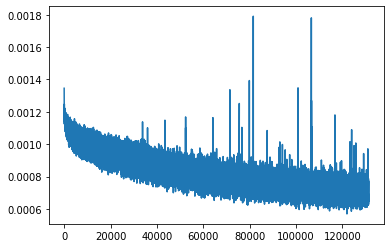

epoch: 71 	 step:0 	 loss: 0.0006394
epoch: 71 	 step:100 	 loss: 0.0007235
epoch: 71 	 step:200 	 loss: 0.0006681
epoch: 71 	 step:300 	 loss: 0.0006494
epoch: 71 	 step:400 	 loss: 0.0006917
epoch: 71 	 step:500 	 loss: 0.0006927
epoch: 71 	 step:600 	 loss: 0.0006423
epoch: 71 	 step:700 	 loss: 0.0006669
epoch: 71 	 step:800 	 loss: 0.0006054
epoch: 71 	 step:900 	 loss: 0.0006749
epoch: 71 	 step:1000 	 loss: 0.0006785
epoch: 71 	 step:1100 	 loss: 0.000719
epoch: 71 	 step:1200 	 loss: 0.0006763
epoch: 71 	 step:1300 	 loss: 0.000689
epoch: 71 	 step:1400 	 loss: 0.0007455
epoch: 71 	 step:1500 	 loss: 0.0007281
epoch: 71 	 step:1600 	 loss: 0.000685
epoch: 71 	 step:1700 	 loss: 0.0006784
epoch: 71 	 step:1800 	 loss: 0.0007147


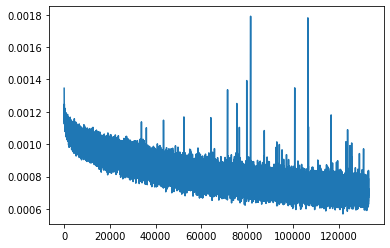

epoch: 72 	 step:0 	 loss: 0.0007357
epoch: 72 	 step:100 	 loss: 0.0006824
epoch: 72 	 step:200 	 loss: 0.000706
epoch: 72 	 step:300 	 loss: 0.0006962
epoch: 72 	 step:400 	 loss: 0.0006875
epoch: 72 	 step:500 	 loss: 0.00069
epoch: 72 	 step:600 	 loss: 0.000662
epoch: 72 	 step:700 	 loss: 0.0007499
epoch: 72 	 step:800 	 loss: 0.0006957
epoch: 72 	 step:900 	 loss: 0.0007205
epoch: 72 	 step:1000 	 loss: 0.0007547
epoch: 72 	 step:1100 	 loss: 0.0006893
epoch: 72 	 step:1200 	 loss: 0.0007334
epoch: 72 	 step:1300 	 loss: 0.0006972
epoch: 72 	 step:1400 	 loss: 0.0006952
epoch: 72 	 step:1500 	 loss: 0.0007503
epoch: 72 	 step:1600 	 loss: 0.0007523
epoch: 72 	 step:1700 	 loss: 0.0007568
epoch: 72 	 step:1800 	 loss: 0.0007315


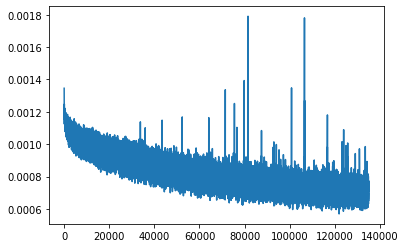

epoch: 73 	 step:0 	 loss: 0.0006579
epoch: 73 	 step:100 	 loss: 0.0007063
epoch: 73 	 step:200 	 loss: 0.0007705
epoch: 73 	 step:300 	 loss: 0.0007921
epoch: 73 	 step:400 	 loss: 0.0006443
epoch: 73 	 step:500 	 loss: 0.0006695
epoch: 73 	 step:600 	 loss: 0.0006406
epoch: 73 	 step:700 	 loss: 0.0007446
epoch: 73 	 step:800 	 loss: 0.0007153
epoch: 73 	 step:900 	 loss: 0.0006864
epoch: 73 	 step:1000 	 loss: 0.0007266
epoch: 73 	 step:1100 	 loss: 0.0006698
epoch: 73 	 step:1200 	 loss: 0.0007476
epoch: 73 	 step:1300 	 loss: 0.0006432
epoch: 73 	 step:1400 	 loss: 0.0007021
epoch: 73 	 step:1500 	 loss: 0.0007224
epoch: 73 	 step:1600 	 loss: 0.0007109
epoch: 73 	 step:1700 	 loss: 0.000661
epoch: 73 	 step:1800 	 loss: 0.0007215


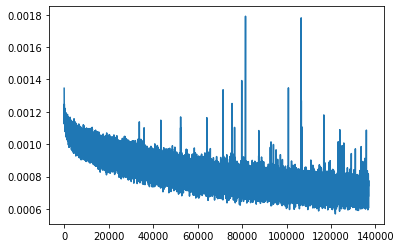

epoch: 74 	 step:0 	 loss: 0.0006302
epoch: 74 	 step:100 	 loss: 0.000692
epoch: 74 	 step:200 	 loss: 0.0007073
epoch: 74 	 step:300 	 loss: 0.0006972
epoch: 74 	 step:400 	 loss: 0.0007696
epoch: 74 	 step:500 	 loss: 0.0006905
epoch: 74 	 step:600 	 loss: 0.0006913
epoch: 74 	 step:700 	 loss: 0.0006687
epoch: 74 	 step:800 	 loss: 0.000749
epoch: 74 	 step:900 	 loss: 0.0007403
epoch: 74 	 step:1000 	 loss: 0.0007035
epoch: 74 	 step:1100 	 loss: 0.000714
epoch: 74 	 step:1200 	 loss: 0.0007119
epoch: 74 	 step:1300 	 loss: 0.0007183
epoch: 74 	 step:1400 	 loss: 0.0006787
epoch: 74 	 step:1500 	 loss: 0.0006679
epoch: 74 	 step:1600 	 loss: 0.0007062
epoch: 74 	 step:1700 	 loss: 0.0007658
epoch: 74 	 step:1800 	 loss: 0.0006575


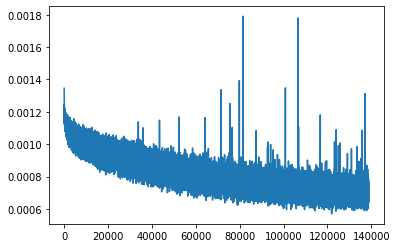

epoch: 75 	 step:0 	 loss: 0.0006808
epoch: 75 	 step:100 	 loss: 0.0006351
epoch: 75 	 step:200 	 loss: 0.000723
epoch: 75 	 step:300 	 loss: 0.0006727
epoch: 75 	 step:400 	 loss: 0.0006782
epoch: 75 	 step:500 	 loss: 0.0007159
epoch: 75 	 step:600 	 loss: 0.0006866
epoch: 75 	 step:700 	 loss: 0.0007073
epoch: 75 	 step:800 	 loss: 0.0007395
epoch: 75 	 step:900 	 loss: 0.0007289
epoch: 75 	 step:1000 	 loss: 0.0006554
epoch: 75 	 step:1100 	 loss: 0.0007225
epoch: 75 	 step:1200 	 loss: 0.0006791
epoch: 75 	 step:1300 	 loss: 0.0006852
epoch: 75 	 step:1400 	 loss: 0.0007235
epoch: 75 	 step:1500 	 loss: 0.0006698
epoch: 75 	 step:1600 	 loss: 0.0007153
epoch: 75 	 step:1700 	 loss: 0.0007046
epoch: 75 	 step:1800 	 loss: 0.000688


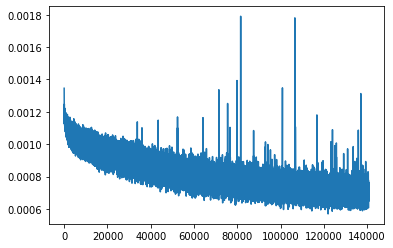

epoch: 76 	 step:0 	 loss: 0.0007034
epoch: 76 	 step:100 	 loss: 0.0007324
epoch: 76 	 step:200 	 loss: 0.0006635
epoch: 76 	 step:300 	 loss: 0.000695
epoch: 76 	 step:400 	 loss: 0.0007208
epoch: 76 	 step:500 	 loss: 0.0006938
epoch: 76 	 step:600 	 loss: 0.0006748
epoch: 76 	 step:700 	 loss: 0.0007202
epoch: 76 	 step:800 	 loss: 0.0006318
epoch: 76 	 step:900 	 loss: 0.0006619
epoch: 76 	 step:1000 	 loss: 0.0006705
epoch: 76 	 step:1100 	 loss: 0.0006841
epoch: 76 	 step:1200 	 loss: 0.0006846
epoch: 76 	 step:1300 	 loss: 0.0006784
epoch: 76 	 step:1400 	 loss: 0.0006749
epoch: 76 	 step:1500 	 loss: 0.0007042
epoch: 76 	 step:1600 	 loss: 0.0006315
epoch: 76 	 step:1700 	 loss: 0.0007479
epoch: 76 	 step:1800 	 loss: 0.000751


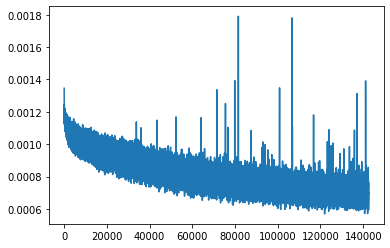

epoch: 77 	 step:0 	 loss: 0.0006538
epoch: 77 	 step:100 	 loss: 0.0007587
epoch: 77 	 step:200 	 loss: 0.0006267
epoch: 77 	 step:300 	 loss: 0.0006874
epoch: 77 	 step:400 	 loss: 0.0007373
epoch: 77 	 step:500 	 loss: 0.000642
epoch: 77 	 step:600 	 loss: 0.0006558
epoch: 77 	 step:700 	 loss: 0.0007041
epoch: 77 	 step:800 	 loss: 0.0007216
epoch: 77 	 step:900 	 loss: 0.0007053
epoch: 77 	 step:1000 	 loss: 0.0007354
epoch: 77 	 step:1100 	 loss: 0.0007524
epoch: 77 	 step:1200 	 loss: 0.0007014
epoch: 77 	 step:1300 	 loss: 0.0007547
epoch: 77 	 step:1400 	 loss: 0.0006921
epoch: 77 	 step:1500 	 loss: 0.0007327
epoch: 77 	 step:1600 	 loss: 0.0006372
epoch: 77 	 step:1700 	 loss: 0.0007025
epoch: 77 	 step:1800 	 loss: 0.0007356


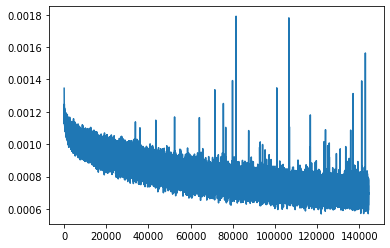

epoch: 78 	 step:0 	 loss: 0.0006711
epoch: 78 	 step:100 	 loss: 0.0007174
epoch: 78 	 step:200 	 loss: 0.0007036
epoch: 78 	 step:300 	 loss: 0.0007071
epoch: 78 	 step:400 	 loss: 0.0006756
epoch: 78 	 step:500 	 loss: 0.000664
epoch: 78 	 step:600 	 loss: 0.0006855
epoch: 78 	 step:700 	 loss: 0.0006627
epoch: 78 	 step:800 	 loss: 0.0006826
epoch: 78 	 step:900 	 loss: 0.0007328
epoch: 78 	 step:1000 	 loss: 0.0006565
epoch: 78 	 step:1100 	 loss: 0.0007437
epoch: 78 	 step:1200 	 loss: 0.0007204
epoch: 78 	 step:1300 	 loss: 0.0006577
epoch: 78 	 step:1400 	 loss: 0.0007292
epoch: 78 	 step:1500 	 loss: 0.0006275
epoch: 78 	 step:1600 	 loss: 0.0007098
epoch: 78 	 step:1700 	 loss: 0.0006639
epoch: 78 	 step:1800 	 loss: 0.000718


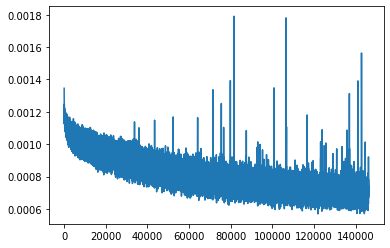

epoch: 79 	 step:0 	 loss: 0.0006614
epoch: 79 	 step:100 	 loss: 0.0007161
epoch: 79 	 step:200 	 loss: 0.0006914
epoch: 79 	 step:300 	 loss: 0.0006688
epoch: 79 	 step:400 	 loss: 0.0006712
epoch: 79 	 step:500 	 loss: 0.0006989
epoch: 79 	 step:600 	 loss: 0.0006494
epoch: 79 	 step:700 	 loss: 0.000666
epoch: 79 	 step:800 	 loss: 0.0007326
epoch: 79 	 step:900 	 loss: 0.0006039
epoch: 79 	 step:1000 	 loss: 0.000713
epoch: 79 	 step:1100 	 loss: 0.0007099
epoch: 79 	 step:1200 	 loss: 0.0007213
epoch: 79 	 step:1300 	 loss: 0.0006822
epoch: 79 	 step:1400 	 loss: 0.0007094
epoch: 79 	 step:1500 	 loss: 0.0006772
epoch: 79 	 step:1600 	 loss: 0.0006872
epoch: 79 	 step:1700 	 loss: 0.0007381
epoch: 79 	 step:1800 	 loss: 0.0006703


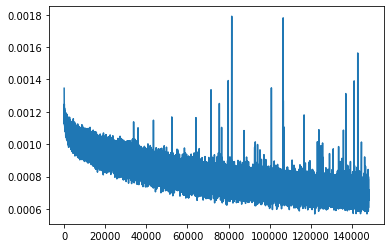

epoch: 80 	 step:0 	 loss: 0.0007196
epoch: 80 	 step:100 	 loss: 0.0006474
epoch: 80 	 step:200 	 loss: 0.0006246
epoch: 80 	 step:300 	 loss: 0.0006992
epoch: 80 	 step:400 	 loss: 0.0006851
epoch: 80 	 step:500 	 loss: 0.000709
epoch: 80 	 step:600 	 loss: 0.0006437
epoch: 80 	 step:700 	 loss: 0.0006873
epoch: 80 	 step:800 	 loss: 0.0006412
epoch: 80 	 step:900 	 loss: 0.0006667
epoch: 80 	 step:1000 	 loss: 0.0006899
epoch: 80 	 step:1100 	 loss: 0.0007391
epoch: 80 	 step:1200 	 loss: 0.0006718
epoch: 80 	 step:1300 	 loss: 0.0007168
epoch: 80 	 step:1400 	 loss: 0.0007261
epoch: 80 	 step:1500 	 loss: 0.0007407
epoch: 80 	 step:1600 	 loss: 0.0006984
epoch: 80 	 step:1700 	 loss: 0.0006699
epoch: 80 	 step:1800 	 loss: 0.0007323


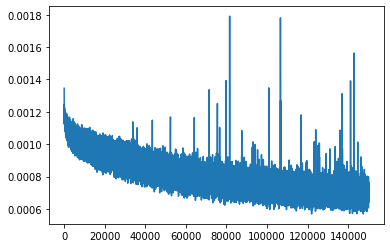

epoch: 81 	 step:0 	 loss: 0.0006915
epoch: 81 	 step:100 	 loss: 0.0006245
epoch: 81 	 step:200 	 loss: 0.0006751
epoch: 81 	 step:300 	 loss: 0.0005767
epoch: 81 	 step:400 	 loss: 0.0006745
epoch: 81 	 step:500 	 loss: 0.000706
epoch: 81 	 step:600 	 loss: 0.0007065
epoch: 81 	 step:700 	 loss: 0.0006498
epoch: 81 	 step:800 	 loss: 0.000719
epoch: 81 	 step:900 	 loss: 0.0007583
epoch: 81 	 step:1000 	 loss: 0.0006748
epoch: 81 	 step:1100 	 loss: 0.0007106
epoch: 81 	 step:1200 	 loss: 0.0007213
epoch: 81 	 step:1300 	 loss: 0.0006915
epoch: 81 	 step:1400 	 loss: 0.0006666
epoch: 81 	 step:1500 	 loss: 0.000643
epoch: 81 	 step:1600 	 loss: 0.0006725
epoch: 81 	 step:1700 	 loss: 0.0006956
epoch: 81 	 step:1800 	 loss: 0.000694


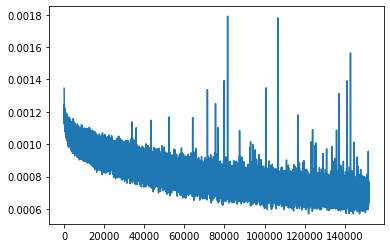

epoch: 82 	 step:0 	 loss: 0.0007431
epoch: 82 	 step:100 	 loss: 0.0006324
epoch: 82 	 step:200 	 loss: 0.0006361
epoch: 82 	 step:300 	 loss: 0.0006593
epoch: 82 	 step:400 	 loss: 0.0006673
epoch: 82 	 step:500 	 loss: 0.0006658
epoch: 82 	 step:600 	 loss: 0.000656
epoch: 82 	 step:700 	 loss: 0.0006958
epoch: 82 	 step:800 	 loss: 0.0006477
epoch: 82 	 step:900 	 loss: 0.0006826
epoch: 82 	 step:1000 	 loss: 0.0006655
epoch: 82 	 step:1100 	 loss: 0.0006776
epoch: 82 	 step:1200 	 loss: 0.0006616
epoch: 82 	 step:1300 	 loss: 0.0006503
epoch: 82 	 step:1400 	 loss: 0.0006123
epoch: 82 	 step:1500 	 loss: 0.0006477
epoch: 82 	 step:1600 	 loss: 0.0006933
epoch: 82 	 step:1700 	 loss: 0.0006886
epoch: 82 	 step:1800 	 loss: 0.0006654


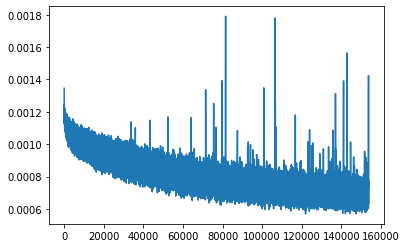

epoch: 83 	 step:0 	 loss: 0.0007301
epoch: 83 	 step:100 	 loss: 0.0006909
epoch: 83 	 step:200 	 loss: 0.000699
epoch: 83 	 step:300 	 loss: 0.000706
epoch: 83 	 step:400 	 loss: 0.0007423
epoch: 83 	 step:500 	 loss: 0.000627
epoch: 83 	 step:600 	 loss: 0.0006773
epoch: 83 	 step:700 	 loss: 0.0006557
epoch: 83 	 step:800 	 loss: 0.0007035
epoch: 83 	 step:900 	 loss: 0.0006973
epoch: 83 	 step:1000 	 loss: 0.0007289
epoch: 83 	 step:1100 	 loss: 0.0006858
epoch: 83 	 step:1200 	 loss: 0.0007365
epoch: 83 	 step:1300 	 loss: 0.0006816
epoch: 83 	 step:1400 	 loss: 0.000693
epoch: 83 	 step:1500 	 loss: 0.0007189
epoch: 83 	 step:1600 	 loss: 0.0006878
epoch: 83 	 step:1700 	 loss: 0.0006408
epoch: 83 	 step:1800 	 loss: 0.0006886


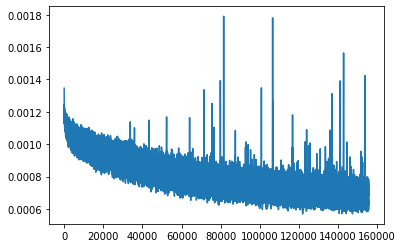

epoch: 84 	 step:0 	 loss: 0.0006548
epoch: 84 	 step:100 	 loss: 0.0006183
epoch: 84 	 step:200 	 loss: 0.000623
epoch: 84 	 step:300 	 loss: 0.0006212
epoch: 84 	 step:400 	 loss: 0.0006642
epoch: 84 	 step:500 	 loss: 0.0006785
epoch: 84 	 step:600 	 loss: 0.0006491
epoch: 84 	 step:700 	 loss: 0.0006713
epoch: 84 	 step:800 	 loss: 0.0007143
epoch: 84 	 step:900 	 loss: 0.0006361
epoch: 84 	 step:1000 	 loss: 0.0006618
epoch: 84 	 step:1100 	 loss: 0.0007311
epoch: 84 	 step:1200 	 loss: 0.0007402
epoch: 84 	 step:1300 	 loss: 0.0006996
epoch: 84 	 step:1400 	 loss: 0.000665
epoch: 84 	 step:1500 	 loss: 0.0007079
epoch: 84 	 step:1600 	 loss: 0.0007153
epoch: 84 	 step:1700 	 loss: 0.0006599
epoch: 84 	 step:1800 	 loss: 0.0006981


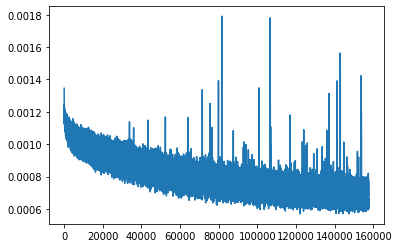

epoch: 85 	 step:0 	 loss: 0.0006289
epoch: 85 	 step:100 	 loss: 0.0006372
epoch: 85 	 step:200 	 loss: 0.0006895
epoch: 85 	 step:300 	 loss: 0.0006231
epoch: 85 	 step:400 	 loss: 0.0006678
epoch: 85 	 step:500 	 loss: 0.0006394
epoch: 85 	 step:600 	 loss: 0.0006449
epoch: 85 	 step:700 	 loss: 0.0007015
epoch: 85 	 step:800 	 loss: 0.0006765
epoch: 85 	 step:900 	 loss: 0.0006861
epoch: 85 	 step:1000 	 loss: 0.000771
epoch: 85 	 step:1100 	 loss: 0.0007084
epoch: 85 	 step:1200 	 loss: 0.0007177
epoch: 85 	 step:1300 	 loss: 0.0006502
epoch: 85 	 step:1400 	 loss: 0.0006568
epoch: 85 	 step:1500 	 loss: 0.000686
epoch: 85 	 step:1600 	 loss: 0.0006965
epoch: 85 	 step:1700 	 loss: 0.0006729
epoch: 85 	 step:1800 	 loss: 0.000686


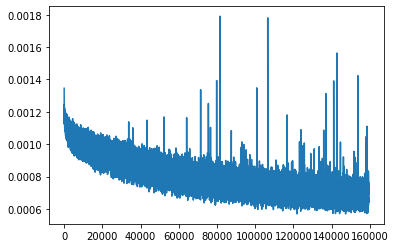

epoch: 86 	 step:0 	 loss: 0.0006577
epoch: 86 	 step:100 	 loss: 0.0006987
epoch: 86 	 step:200 	 loss: 0.0006926
epoch: 86 	 step:300 	 loss: 0.0006741
epoch: 86 	 step:400 	 loss: 0.000653
epoch: 86 	 step:500 	 loss: 0.000701
epoch: 86 	 step:600 	 loss: 0.000653
epoch: 86 	 step:700 	 loss: 0.0007018
epoch: 86 	 step:800 	 loss: 0.0006798
epoch: 86 	 step:900 	 loss: 0.0007137
epoch: 86 	 step:1000 	 loss: 0.0007317
epoch: 86 	 step:1100 	 loss: 0.0006676
epoch: 86 	 step:1200 	 loss: 0.0006653
epoch: 86 	 step:1300 	 loss: 0.0006857
epoch: 86 	 step:1400 	 loss: 0.000658
epoch: 86 	 step:1500 	 loss: 0.0006781
epoch: 86 	 step:1600 	 loss: 0.000706
epoch: 86 	 step:1700 	 loss: 0.0006715
epoch: 86 	 step:1800 	 loss: 0.0006518


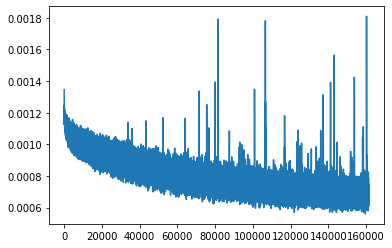

epoch: 87 	 step:0 	 loss: 0.0006703
epoch: 87 	 step:100 	 loss: 0.0007135
epoch: 87 	 step:200 	 loss: 0.0006345
epoch: 87 	 step:300 	 loss: 0.0006551
epoch: 87 	 step:400 	 loss: 0.0005967
epoch: 87 	 step:500 	 loss: 0.000698
epoch: 87 	 step:600 	 loss: 0.0006379
epoch: 87 	 step:700 	 loss: 0.0007149
epoch: 87 	 step:800 	 loss: 0.0006428
epoch: 87 	 step:900 	 loss: 0.0007016
epoch: 87 	 step:1000 	 loss: 0.0006897
epoch: 87 	 step:1100 	 loss: 0.0006466
epoch: 87 	 step:1200 	 loss: 0.0006794
epoch: 87 	 step:1300 	 loss: 0.0006823
epoch: 87 	 step:1400 	 loss: 0.0007059
epoch: 87 	 step:1500 	 loss: 0.0006918
epoch: 87 	 step:1600 	 loss: 0.0006328
epoch: 87 	 step:1700 	 loss: 0.0006486
epoch: 87 	 step:1800 	 loss: 0.0006859


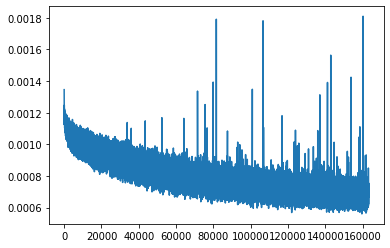

epoch: 88 	 step:0 	 loss: 0.00064
epoch: 88 	 step:100 	 loss: 0.000694
epoch: 88 	 step:200 	 loss: 0.0006556
epoch: 88 	 step:300 	 loss: 0.0006895
epoch: 88 	 step:400 	 loss: 0.0006241
epoch: 88 	 step:500 	 loss: 0.0006838
epoch: 88 	 step:600 	 loss: 0.0006787
epoch: 88 	 step:700 	 loss: 0.0007069
epoch: 88 	 step:800 	 loss: 0.0006335
epoch: 88 	 step:900 	 loss: 0.0006607
epoch: 88 	 step:1000 	 loss: 0.0006268
epoch: 88 	 step:1100 	 loss: 0.0007408
epoch: 88 	 step:1200 	 loss: 0.0006347
epoch: 88 	 step:1300 	 loss: 0.0006737
epoch: 88 	 step:1400 	 loss: 0.0007196
epoch: 88 	 step:1500 	 loss: 0.0007438
epoch: 88 	 step:1600 	 loss: 0.000683
epoch: 88 	 step:1700 	 loss: 0.0006913
epoch: 88 	 step:1800 	 loss: 0.0007039


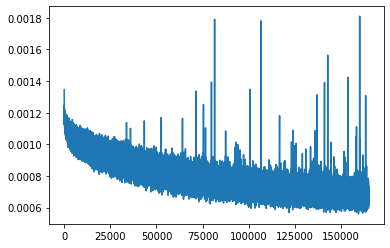

epoch: 89 	 step:0 	 loss: 0.0006324
epoch: 89 	 step:100 	 loss: 0.0006422
epoch: 89 	 step:200 	 loss: 0.0006456
epoch: 89 	 step:300 	 loss: 0.0006657
epoch: 89 	 step:400 	 loss: 0.0006489
epoch: 89 	 step:500 	 loss: 0.0006363
epoch: 89 	 step:600 	 loss: 0.0006762
epoch: 89 	 step:700 	 loss: 0.0007435
epoch: 89 	 step:800 	 loss: 0.0006897
epoch: 89 	 step:900 	 loss: 0.0007019
epoch: 89 	 step:1000 	 loss: 0.00068
epoch: 89 	 step:1100 	 loss: 0.0006918
epoch: 89 	 step:1200 	 loss: 0.0006747
epoch: 89 	 step:1300 	 loss: 0.0006777
epoch: 89 	 step:1400 	 loss: 0.0006514
epoch: 89 	 step:1500 	 loss: 0.0006632
epoch: 89 	 step:1600 	 loss: 0.0006866
epoch: 89 	 step:1700 	 loss: 0.0006806
epoch: 89 	 step:1800 	 loss: 0.0006883


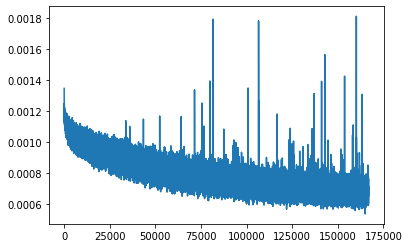

epoch: 90 	 step:0 	 loss: 0.0006072
epoch: 90 	 step:100 	 loss: 0.0006272
epoch: 90 	 step:200 	 loss: 0.0006316
epoch: 90 	 step:300 	 loss: 0.0006424
epoch: 90 	 step:400 	 loss: 0.0006578
epoch: 90 	 step:500 	 loss: 0.0006838
epoch: 90 	 step:600 	 loss: 0.0006492
epoch: 90 	 step:700 	 loss: 0.0006618
epoch: 90 	 step:800 	 loss: 0.0006853
epoch: 90 	 step:900 	 loss: 0.0007001
epoch: 90 	 step:1000 	 loss: 0.0006536
epoch: 90 	 step:1100 	 loss: 0.0006622
epoch: 90 	 step:1200 	 loss: 0.0006916
epoch: 90 	 step:1300 	 loss: 0.0006755
epoch: 90 	 step:1400 	 loss: 0.0006463
epoch: 90 	 step:1500 	 loss: 0.0006908
epoch: 90 	 step:1600 	 loss: 0.0006719
epoch: 90 	 step:1700 	 loss: 0.0006892
epoch: 90 	 step:1800 	 loss: 0.0006362


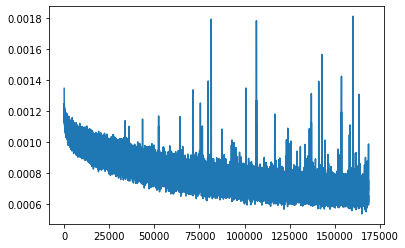

epoch: 91 	 step:0 	 loss: 0.000688
epoch: 91 	 step:100 	 loss: 0.0006795
epoch: 91 	 step:200 	 loss: 0.0005963
epoch: 91 	 step:300 	 loss: 0.0007187
epoch: 91 	 step:400 	 loss: 0.0007043
epoch: 91 	 step:500 	 loss: 0.0006385
epoch: 91 	 step:600 	 loss: 0.00067
epoch: 91 	 step:700 	 loss: 0.0006688
epoch: 91 	 step:800 	 loss: 0.0006721
epoch: 91 	 step:900 	 loss: 0.0006462
epoch: 91 	 step:1000 	 loss: 0.0006745
epoch: 91 	 step:1100 	 loss: 0.0006878
epoch: 91 	 step:1200 	 loss: 0.0006435
epoch: 91 	 step:1300 	 loss: 0.0006392
epoch: 91 	 step:1400 	 loss: 0.000709
epoch: 91 	 step:1500 	 loss: 0.0006709
epoch: 91 	 step:1600 	 loss: 0.0006677
epoch: 91 	 step:1700 	 loss: 0.0006587
epoch: 91 	 step:1800 	 loss: 0.000634


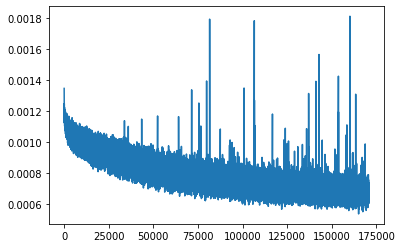

epoch: 92 	 step:0 	 loss: 0.0006664
epoch: 92 	 step:100 	 loss: 0.0006502
epoch: 92 	 step:200 	 loss: 0.0006418
epoch: 92 	 step:300 	 loss: 0.0006653
epoch: 92 	 step:400 	 loss: 0.0006516
epoch: 92 	 step:500 	 loss: 0.0007287
epoch: 92 	 step:600 	 loss: 0.0008185
epoch: 92 	 step:700 	 loss: 0.0006724
epoch: 92 	 step:800 	 loss: 0.0006706
epoch: 92 	 step:900 	 loss: 0.0006951
epoch: 92 	 step:1000 	 loss: 0.0007039
epoch: 92 	 step:1100 	 loss: 0.0006432
epoch: 92 	 step:1200 	 loss: 0.0007027
epoch: 92 	 step:1300 	 loss: 0.0006705
epoch: 92 	 step:1400 	 loss: 0.0006629
epoch: 92 	 step:1500 	 loss: 0.0006312
epoch: 92 	 step:1600 	 loss: 0.0006945
epoch: 92 	 step:1700 	 loss: 0.0006473
epoch: 92 	 step:1800 	 loss: 0.0006465


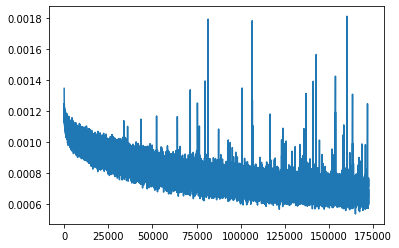

epoch: 93 	 step:0 	 loss: 0.0006541
epoch: 93 	 step:100 	 loss: 0.0006537
epoch: 93 	 step:200 	 loss: 0.0006767
epoch: 93 	 step:300 	 loss: 0.0007257
epoch: 93 	 step:400 	 loss: 0.00074
epoch: 93 	 step:500 	 loss: 0.0006326
epoch: 93 	 step:600 	 loss: 0.0007269
epoch: 93 	 step:700 	 loss: 0.0006576
epoch: 93 	 step:800 	 loss: 0.0006652
epoch: 93 	 step:900 	 loss: 0.0006809
epoch: 93 	 step:1000 	 loss: 0.0006645
epoch: 93 	 step:1100 	 loss: 0.0006637
epoch: 93 	 step:1200 	 loss: 0.0006796
epoch: 93 	 step:1300 	 loss: 0.0007219
epoch: 93 	 step:1400 	 loss: 0.0006932
epoch: 93 	 step:1500 	 loss: 0.0007108
epoch: 93 	 step:1600 	 loss: 0.0007034
epoch: 93 	 step:1700 	 loss: 0.0006564
epoch: 93 	 step:1800 	 loss: 0.0007149


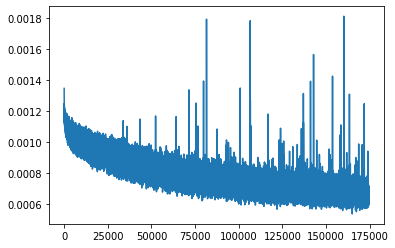

epoch: 94 	 step:0 	 loss: 0.0006088
epoch: 94 	 step:100 	 loss: 0.0006752
epoch: 94 	 step:200 	 loss: 0.000631
epoch: 94 	 step:300 	 loss: 0.0007595
epoch: 94 	 step:400 	 loss: 0.0006471
epoch: 94 	 step:500 	 loss: 0.0006544
epoch: 94 	 step:600 	 loss: 0.0007118
epoch: 94 	 step:700 	 loss: 0.0006466
epoch: 94 	 step:800 	 loss: 0.0006385
epoch: 94 	 step:900 	 loss: 0.0007002
epoch: 94 	 step:1000 	 loss: 0.0007364
epoch: 94 	 step:1100 	 loss: 0.0006902
epoch: 94 	 step:1200 	 loss: 0.0006438
epoch: 94 	 step:1300 	 loss: 0.0006964
epoch: 94 	 step:1400 	 loss: 0.0007548
epoch: 94 	 step:1500 	 loss: 0.0006346
epoch: 94 	 step:1600 	 loss: 0.0007171
epoch: 94 	 step:1700 	 loss: 0.0006861
epoch: 94 	 step:1800 	 loss: 0.0006805


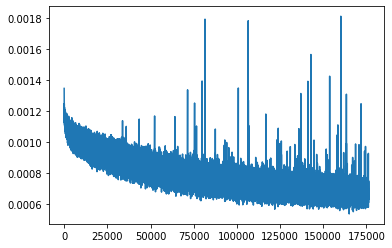

epoch: 95 	 step:0 	 loss: 0.0006548
epoch: 95 	 step:100 	 loss: 0.0007823
epoch: 95 	 step:200 	 loss: 0.0007438
epoch: 95 	 step:300 	 loss: 0.0006802
epoch: 95 	 step:400 	 loss: 0.0006765
epoch: 95 	 step:500 	 loss: 0.0006366
epoch: 95 	 step:600 	 loss: 0.0006746
epoch: 95 	 step:700 	 loss: 0.0006689
epoch: 95 	 step:800 	 loss: 0.0006506
epoch: 95 	 step:900 	 loss: 0.0006401
epoch: 95 	 step:1000 	 loss: 0.0006489
epoch: 95 	 step:1100 	 loss: 0.0006121
epoch: 95 	 step:1200 	 loss: 0.0005945
epoch: 95 	 step:1300 	 loss: 0.0006721
epoch: 95 	 step:1400 	 loss: 0.0006651
epoch: 95 	 step:1500 	 loss: 0.0007011
epoch: 95 	 step:1600 	 loss: 0.0006615
epoch: 95 	 step:1700 	 loss: 0.0006443
epoch: 95 	 step:1800 	 loss: 0.0006589


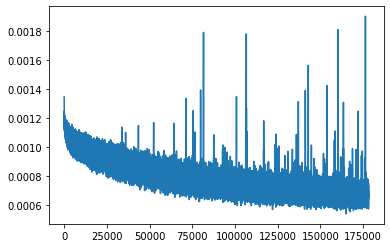

epoch: 96 	 step:0 	 loss: 0.0007202
epoch: 96 	 step:100 	 loss: 0.0006571
epoch: 96 	 step:200 	 loss: 0.0006439
epoch: 96 	 step:300 	 loss: 0.0006158
epoch: 96 	 step:400 	 loss: 0.0006581
epoch: 96 	 step:500 	 loss: 0.0006689
epoch: 96 	 step:600 	 loss: 0.0006479
epoch: 96 	 step:700 	 loss: 0.0006867
epoch: 96 	 step:800 	 loss: 0.0006139
epoch: 96 	 step:900 	 loss: 0.0006869
epoch: 96 	 step:1000 	 loss: 0.0006438
epoch: 96 	 step:1100 	 loss: 0.0007315
epoch: 96 	 step:1200 	 loss: 0.0007277
epoch: 96 	 step:1300 	 loss: 0.0007119
epoch: 96 	 step:1400 	 loss: 0.0006942
epoch: 96 	 step:1500 	 loss: 0.0006668
epoch: 96 	 step:1600 	 loss: 0.0006394
epoch: 96 	 step:1700 	 loss: 0.0007575
epoch: 96 	 step:1800 	 loss: 0.0006489


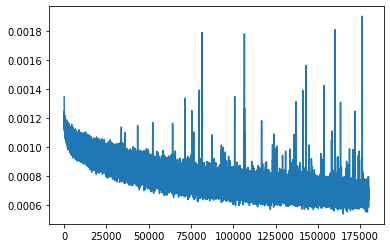

epoch: 97 	 step:0 	 loss: 0.0006708
epoch: 97 	 step:100 	 loss: 0.0005844
epoch: 97 	 step:200 	 loss: 0.0006586
epoch: 97 	 step:300 	 loss: 0.0007363
epoch: 97 	 step:400 	 loss: 0.0005534
epoch: 97 	 step:500 	 loss: 0.0007036
epoch: 97 	 step:600 	 loss: 0.000673
epoch: 97 	 step:700 	 loss: 0.0006431
epoch: 97 	 step:800 	 loss: 0.0006712
epoch: 97 	 step:900 	 loss: 0.0006352
epoch: 97 	 step:1000 	 loss: 0.0007181
epoch: 97 	 step:1100 	 loss: 0.0006654
epoch: 97 	 step:1200 	 loss: 0.0006725
epoch: 97 	 step:1300 	 loss: 0.0006424
epoch: 97 	 step:1400 	 loss: 0.0006842
epoch: 97 	 step:1500 	 loss: 0.0006498
epoch: 97 	 step:1600 	 loss: 0.0006864
epoch: 97 	 step:1700 	 loss: 0.000726
epoch: 97 	 step:1800 	 loss: 0.0006364


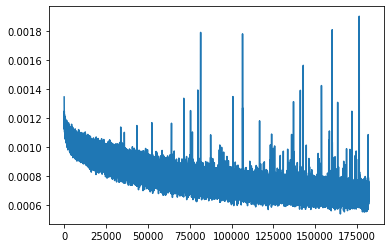

epoch: 98 	 step:0 	 loss: 0.0006615
epoch: 98 	 step:100 	 loss: 0.0006668
epoch: 98 	 step:200 	 loss: 0.0006561
epoch: 98 	 step:300 	 loss: 0.0006824
epoch: 98 	 step:400 	 loss: 0.0006522
epoch: 98 	 step:500 	 loss: 0.0006509
epoch: 98 	 step:600 	 loss: 0.0006256
epoch: 98 	 step:700 	 loss: 0.0006428
epoch: 98 	 step:800 	 loss: 0.000716
epoch: 98 	 step:900 	 loss: 0.000684
epoch: 98 	 step:1000 	 loss: 0.0006506
epoch: 98 	 step:1100 	 loss: 0.0006365
epoch: 98 	 step:1200 	 loss: 0.0006344
epoch: 98 	 step:1300 	 loss: 0.0006815
epoch: 98 	 step:1400 	 loss: 0.0006367
epoch: 98 	 step:1500 	 loss: 0.0006427
epoch: 98 	 step:1600 	 loss: 0.0006418
epoch: 98 	 step:1700 	 loss: 0.0007219
epoch: 98 	 step:1800 	 loss: 0.0006536


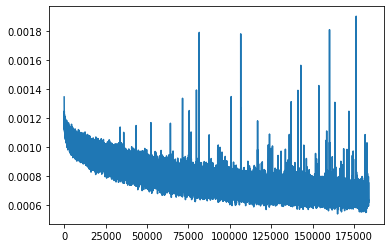

epoch: 99 	 step:0 	 loss: 0.0006418
epoch: 99 	 step:100 	 loss: 0.0006319
epoch: 99 	 step:200 	 loss: 0.0006171
epoch: 99 	 step:300 	 loss: 0.0006682
epoch: 99 	 step:400 	 loss: 0.0006611
epoch: 99 	 step:500 	 loss: 0.0006192
epoch: 99 	 step:600 	 loss: 0.0006359
epoch: 99 	 step:700 	 loss: 0.0006773
epoch: 99 	 step:800 	 loss: 0.0006871
epoch: 99 	 step:900 	 loss: 0.0006711
epoch: 99 	 step:1000 	 loss: 0.0006396
epoch: 99 	 step:1100 	 loss: 0.0006615
epoch: 99 	 step:1200 	 loss: 0.0006327
epoch: 99 	 step:1300 	 loss: 0.0006772
epoch: 99 	 step:1400 	 loss: 0.0006415
epoch: 99 	 step:1500 	 loss: 0.0006748
epoch: 99 	 step:1600 	 loss: 0.000677
epoch: 99 	 step:1700 	 loss: 0.0006269
epoch: 99 	 step:1800 	 loss: 0.0006416


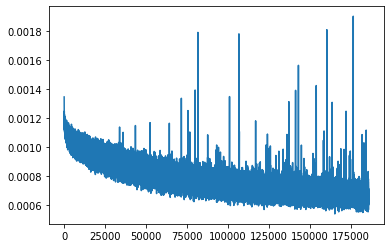

epoch: 100 	 step:0 	 loss: 0.0006734
epoch: 100 	 step:100 	 loss: 0.0007111
epoch: 100 	 step:200 	 loss: 0.0006193
epoch: 100 	 step:300 	 loss: 0.0007221
epoch: 100 	 step:400 	 loss: 0.0006415
epoch: 100 	 step:500 	 loss: 0.000693
epoch: 100 	 step:600 	 loss: 0.0006396
epoch: 100 	 step:700 	 loss: 0.0006186
epoch: 100 	 step:800 	 loss: 0.0006751
epoch: 100 	 step:900 	 loss: 0.0006693
epoch: 100 	 step:1000 	 loss: 0.0006475
epoch: 100 	 step:1100 	 loss: 0.0006725
epoch: 100 	 step:1200 	 loss: 0.0006636
epoch: 100 	 step:1300 	 loss: 0.000665
epoch: 100 	 step:1400 	 loss: 0.0006493
epoch: 100 	 step:1500 	 loss: 0.0006454
epoch: 100 	 step:1600 	 loss: 0.000737
epoch: 100 	 step:1700 	 loss: 0.0006497
epoch: 100 	 step:1800 	 loss: 0.0006904


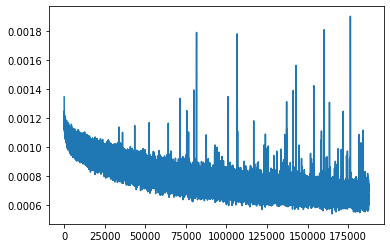

In [14]:
### TRAIN MODEL ###

num_epochs = 100

history = train_model(gen, opt, device, dataloader['train'], epochs=num_epochs)

In [15]:
def test_generator(model, device, testloader, one_batch=False):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        test_images.append(data.cpu().numpy())
        _, magn, _ = calc_fourier(data)
        out_Phs = model(magn)
        out_phs = torch.rfft(out_Phs, 2, onesided=False)
        out_phs = out_phs / torch.norm(out_phs, dim=-1)[..., None]
        out_ft = magn[..., None] * out_phs
        out = torch.irfft(out_ft, 2, onesided=False)
        
        outputs.append(out.cpu().detach().numpy())
        if one_batch: break
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [16]:
# Calculate test predictions #

test_original, test_predicted = test_generator(gen, device, dataloader['test'])
print(test_original.shape)
print(test_predicted.shape)

(8000, 1, 28, 28)
(8000, 1, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


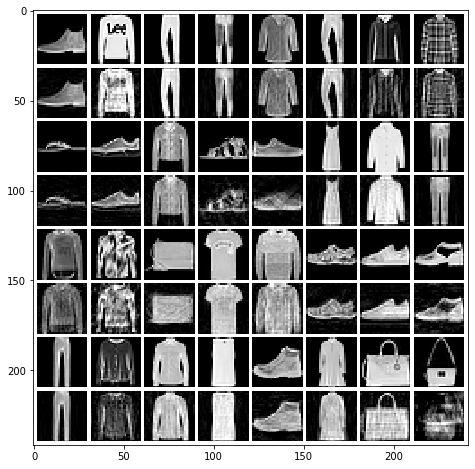

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


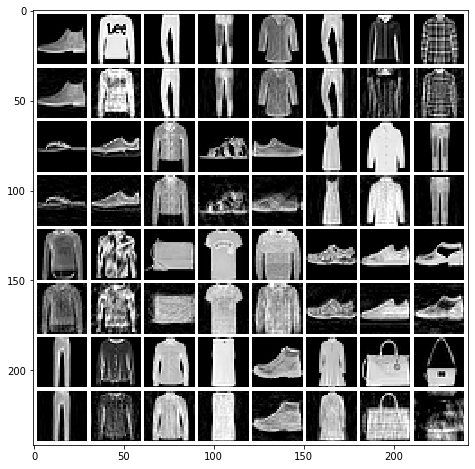

In [17]:
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/Fashion/end-to-end/phase-prediction/phase-real.png")

print("Registered:")
results_reg = register_croco(test_predicted[:32], test_original[:32])
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/Fashion/end-to-end/phase-prediction/phase-real-reg.png")

In [18]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.02024463385907893, std: 0.019584348535122743
  MAE: 0.09102458627603482, std: 0.04482609512450813
  SSIM: 0.6751121569283838, std: 0.1820163540626525
  Sharpness: 0.1564672047073993, std: 0.0715024943448254
  PhCo-MSE: 0.020626247885388693, std: 0.02386748587368572
  PhCo-MAE: 0.09164958203837159, std: 0.04979987536331387
  PhCo-SSIM: 0.6772087640416437, std: 0.1906625406842985
  CroCo-MSE: 0.017541821517966127, std: 0.01589748965261098
  CroCo-MAE: 0.08716463148084586, std: 0.04121414481953969
  CroCo-SSIM: 0.6949503417692652, std: 0.16257319072136903

Magnitude error:
  MSE Magnitude: 4.040456547503446e-12, std: 2.3998734638488904e-12

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-0.88, 1.85] - should be in [0, 1]

Markdown table values:
 0.02024 | 0.09102 | 0.6751 | 0.1565 | 0.02063 | 0.09165 | 0.6772 | 0.01754 | 0.08716 | 0.6950 | 0.000000000004040 |


## Evaluation for different FC  (1024 samples)


| Nr | Loss | Size | epochs| MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- |
| 2 | L2 | 2048 | 100 | 0.02024 | 0.09102 | 0.6751 | 0.1565 | 0.02063 | 0.09165 | 0.6772 | 0.01754 | 0.08716 | 0.6950 | 0.000000000004040 |

Signal error:
  MSE: 0.02024463385907893, std: 0.019584348535122743
  MAE: 0.09102458627603482, std: 0.04482609512450813
  SSIM: 0.6751121569283838, std: 0.1820163540626525
  Sharpness: 0.1564672047073993, std: 0.0715024943448254
  PhCo-MSE: 0.020626247885388693, std: 0.02386748587368572
  PhCo-MAE: 0.09164958203837159, std: 0.04979987536331387
  PhCo-SSIM: 0.6772087640416437, std: 0.1906625406842985
  CroCo-MSE: 0.017541821517966127, std: 0.01589748965261098
  CroCo-MAE: 0.08716463148084586, std: 0.04121414481953969
  CroCo-SSIM: 0.6949503417692652, std: 0.16257319072136903

Magnitude error:
  MSE Magnitude: 4.040456547503446e-12, std: 2.3998734638488904e-12

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-0.88, 1.85] - should be in [0, 1]